# Regret Heuristics

## Imports

In [42]:
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import seaborn as sns
import random
random.seed(42)
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Constants Declarations

In [43]:
TSPA_PATH = "../data/TSPA.csv"
TSPB_PATH = "../data/TSPB.csv"

## Read Data

In [44]:
df = pd.read_csv(TSPA_PATH, sep=";", header=None)
df.columns = ["x", "y", "val"]
df

x     y   val
0    1355  1796   496
1    2524   387   414
2    2769   430   500
3    3131  1199  1133
4     661    87   903
..    ...   ...   ...
195   189  1151  1145
196  3688   759   727
197   973   984  1637
198   910  1383  1255
199   262  1669  1307

[200 rows x 3 columns]

## Utils

In [4]:
def math_round(n):
    '''
    Mathematically rounds up to the nearest integer, always rounds up for 0.5

    ParametersL
    n: floating point number to round
    '''
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [5]:
def plot_nodes_with_lines(df, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = 'Nodes with Color-Scaled Values' if connections is None else 'Nodes with Values and Connections'
    plt.title(title)
    plt.grid(False)
    plt.show()


def get_distance_matrix(df, distance_function):
    """
    Calculates the distance matrix for a set of nodes using the given distance function.

    Parameters:
    nodes: DataFrame of nodes, each with 'x', 'y', and 'val'.
    distance_function: function that takes two points (x1, y1) and (x2, y2) and returns the distance.

    Returns:
    A 2D numpy array representing the distance matrix.
    """
    positions = df[["x", "y"]]
    num_nodes = len(positions)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int64)

    for i in range(num_nodes):
        for j in range(i, num_nodes):
            dist = round(distance_function(positions.iloc[i], positions.iloc[j]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    return distance_matrix


def calculate_score(solution, matrix, weights):
    '''
    Calculates solution score based on the matrix of distances and provided weights array.

    Parameters:
    solution: List or array of the solution
    matrix: Numpy array with node distances (2D)
    weights: Numpy array with node weights (1D - vector)
    '''
    score = 0
    for i in range(len(solution)-1):
        node_1 = solution[i]
        node_2 = solution[i+1]
        score += (matrix[node_1][node_2] + weights[node_1])
    node_1 = solution[-1]
    node_2 = solution[0]
    score += (matrix[node_1][node_2] + weights[node_1])
    return score

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [6]:
def find_second_node_closest(start_node, matrix, weights):
    '''
    Finds the second node for the TSP cycle using a greedy approach, selecting the node closest
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    second_node = np.argmin(distance_matrix[:, start_node] + weights)
    return second_node

def find_second_node_regret(start_node, non_cycle_nodes, matrix, weights):
    '''
    Finds the second node using a regret-based heuristic. The regret is calculated as the difference 
    between the closest and second closest nodes, and the node with the highest regret is selected.

    Parameters:
    start_node: int, the index of the node from which the cycle starts.
    non_cycle_nodes: set of remaining nodes that are not yet in the cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    best_node: int, the index of the selected second node based on the regret heuristic.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    best_node = None
    best_regret = -np.inf
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        if regret > best_regret:
            best_regret = regret
            best_node = node
    return best_node

def find_third_node(node_1, node_2, matrix, weights):
    '''
    Finds the third node for the TSP cycle by selecting the node that minimizes the total 
    distance from both the first and second nodes, considering node weights.

    Parameters:
    node_1: int, the index of the first node.
    node_2: int, the index of the second node.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    third_node: int, the index of the third node to complete the initial triangle of the cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)
    np.fill_diagonal(distance_matrix, np.inf)
    third_node = np.argmin(distance_matrix[:, node_1] + distance_matrix[:, node_2] + weights)
    return third_node


def calculate_score_three(solution, matrix, weights):
    '''
    Calculates the score (total distance) for a TSP cycle for the first three nodes. 

    Parameters:
    solution: list of three ints representing the node indices of the current cycle.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    score = 0
    node_1 = solution[0]
    node_2 = solution[1]
    node_3 = solution[2]
    score += matrix[node_1][node_2] + weights[node_1]
    score += matrix[node_2][node_3] + weights[node_2]
    score += matrix[node_3][node_1] + weights[node_3]
    return score

def update_score(solution, score, node, insert_location, matrix, weights):
    '''
    Updates the total score after inserting a node at a specified location in the solution. 

    Parameters:
    solution: List of nodes representing the current cycle.
    score: The current total score (cost) of the cycle before the node is inserted.
    node: int, the node to be inserted into the solution.
    insert_location: int, the index at which the node will be inserted.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    '''
    node_before = solution[insert_location - 1]
    node_after = solution[insert_location]
    score -= matrix[node_before][node_after]
    score += matrix[node_before][node] + matrix[node][node_after] + weights[node]
    return score

def find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight):
    '''
    Finds the second node for the TSP cycle using a mix of a weighted greedy and regret approaches
    to the start node based on the distance matrix and weights.

    Parameters:
    start_node: int, the index of the node from which the search for the second node starts.
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing weights associated with each node.

    Returns:
    second_node: int, the index of the second node selected to form the initial cycle.
    '''
    distance_matrix = np.copy(matrix)
    distance_matrix = distance_matrix.astype(np.float64)

    greedy_scores = []
    ordered_nodes = list(non_cycle_nodes)
    for node in non_cycle_nodes:
        greedy_score = distance_matrix[start_node][node] + weights[node]
        greedy_scores.append(greedy_score)

    regret_scores = []
    for node in non_cycle_nodes:
        start_node_cost = distance_matrix[start_node][node] + weights[node]
        distance_matrix[start_node][node] = np.inf
        smallest_cost = np.argmin(distance_matrix[node] + weights)
        regret = smallest_cost - start_node_cost
        regret_scores.append(regret)

    greedy_scores = np.array(greedy_scores)
    regret_scores = np.array(regret_scores)
    total_scores = ((1 + regret_weight) * greedy_score) + (regret_weight * regret_scores)
    total_scores, ordered_nodes = zip(*sorted(zip(total_scores, ordered_nodes)))
    return ordered_nodes[0]

In [7]:
def random_solution(distance_matrix, weights, start_node):
    '''
    Returns a random solution to the TSP problem based on the provided distance matrix.

    Parameters:
    distance_matrix: numpy.array containing distances between the nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''

    remaining_nodes = list(range(len(distance_matrix)))
    remaining_nodes.remove(start_node)
    np.random.shuffle(remaining_nodes)
    solution = [start_node] + remaining_nodes[:len(distance_matrix)//2 - 1]
    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [8]:
def nearest_neighbor_all(distance_matrix, weights, start_node):
    '''
    Greedy solution to the TSP problem that selects the closest node from all previously selected.

    Parameters:
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    start_node: int, the index of the node from which the cycle starts.
    '''
    d_matrix = np.copy(distance_matrix)
    d_matrix = d_matrix.astype(np.float64)
    np.fill_diagonal(d_matrix, np.inf)
    num_nodes = d_matrix.shape[0]

    d_matrix[start_node] = np.inf
    
    solution = [start_node]

    i = 1
    while i < num_nodes//2:
        j = 0
        best_found = np.inf
        insert_node_idx = None
        insert_node_nearest = None    

        while j < i:
            tested_node = solution[j]

            nearest_node = np.argmin(d_matrix[:, tested_node] + weights)
            min_cost = d_matrix[:, tested_node][nearest_node] + weights[nearest_node]

            if min_cost < best_found:
                best_found = min_cost
                insert_node_idx = j+1
                insert_node_nearest = nearest_node            

            j += 1

        d_matrix[insert_node_nearest] = np.inf
        solution.insert(insert_node_idx, insert_node_nearest)

        i += 1

    score = calculate_score(solution, distance_matrix, weights)
    return solution, score

In [66]:
def greedy_regret_cycle(matrix, weights, start_node):
    '''
    Implements a greedy regret cycle algorithm with regret to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    solution = [start_node]
    non_cycle_nodes = set([i for i in range(len(weights))])
    non_cycle_nodes.remove(start_node)
    num_iterations = int((len(weights) // 2) - 3)
    second_node = find_second_node_closest(start_node, matrix, weights)
    #second_node = find_second_node_regret(start_node, non_cycle_nodes, matrix, weights)
    solution.append(second_node)
    non_cycle_nodes.remove(second_node)
    third_node = find_third_node(start_node, second_node, matrix, weights)
    solution.append(third_node)
    non_cycle_nodes.remove(third_node)
    score = calculate_score_three(solution, matrix, weights)

    for i in range(num_iterations):
        best_regret = -np.inf
        best_node = None
        best_location = None
        best_score = None
        for node in non_cycle_nodes:
            score_one_location = None
            score_two_location = None
            score_one = np.inf
            score_two = np.inf
            for insert_location in range(len(solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                if temp_score < score_one:
                    score_two = score_one
                    score_one = temp_score
                    score_two_location = score_one_location
                    score_one_location = insert_location
                elif temp_score < score_two:
                    score_two = temp_score
                    score_two_location = insert_location
            regret_location = score_one_location
            regret = score_two - score_one
            if regret > best_regret:
                best_regret = regret
                best_node = node
                best_location = regret_location
                best_score = score_one
        solution.insert(best_location, best_node)
        score = best_score
        non_cycle_nodes.remove(best_node)
    return solution, score

In [61]:
def greedy_regret_cycle_weighted(matrix, weights, start_node, regret_weight=-0.5):
    '''
    Implements a weighted greedy cycle algorithm with regret to solve the Traveling Salesman Problem (TSP).

    Parameters:
    matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    starting_node: int, the index of the node from which the cycle starts.
    '''
    solution = [start_node]
    non_cycle_nodes = set([i for i in range(len(weights))])
    non_cycle_nodes.remove(start_node)
    num_iterations = int((len(weights) // 2) - 3)
    second_node = find_second_node_closest_weighted(start_node, non_cycle_nodes, matrix, weights, regret_weight)
    #second_node = find_second_node_closest(start_node, matrix, weights)
    solution.append(second_node)
    non_cycle_nodes.remove(second_node)
    third_node = find_third_node(start_node, second_node, matrix, weights)
    solution.append(third_node)
    non_cycle_nodes.remove(third_node)
    score = calculate_score_three(solution, matrix, weights)

    for i in range(num_iterations):
        best_weighted_score = np.inf
        best_score = None
        best_node = None
        best_location = None
        for node in non_cycle_nodes:
            score_one_location = None
            score_two_location = None
            score_one = np.inf
            score_two = np.inf
            for insert_location in range(len(solution)):
                #insert_location = (insert_location + 1) % len(solution) MIGHT NEED TO UNCOMMENT THIS
                temp_score = update_score(solution, score, node, insert_location, matrix, weights)
                if temp_score < score_one:
                    score_two = score_one
                    score_one = temp_score
                    score_two_location = score_one_location
                    score_one_location = insert_location
                elif temp_score < score_two:
                    score_two = temp_score
                    score_two_location = insert_location
            regret_location = score_one_location
            regret = score_two - score_one
            score_difference = score_one - score
            weghted_score = ((1 + regret_weight) * score_difference) + (regret_weight * regret)
            if weghted_score < best_weighted_score:
                best_weighted_score = weghted_score
                best_node = node
                best_location = regret_location
                best_score = score_one
        solution.insert(best_location, best_node)
        score = best_score
        non_cycle_nodes.remove(best_node)
    return solution, score

In [47]:
distance_matrix = get_distance_matrix(df, euclidean_distance)
pd.DataFrame(distance_matrix)

0     1     2     3     4     5     6     7     8     9    ...   190  \
0       0  1831  1966  1874  1845  1097  1658  2297  2193  1364  ...  1977   
1    1831     0   249  1014  1887  1985   802  1872  1270  1027  ...  2173   
2    1966   249     0   850  2136  2209  1050  1698  1066   981  ...  2421   
3    1874  1014   850     0  2709  2513  1715   858   344   512  ...  2976   
4    1845  1887  2136  2709     0   888  1091  3487  3036  2396  ...   288   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
195  1333  2457  2679  2942  1164   473  1834  3537  3286  2486  ...  1087   
196  2553  1222   976   710  3101  3068  2023  1124   517  1212  ...  3384   
197   897  1662  1880  2169   950   345  1113  2824  2513  1741  ...  1085   
198   607  1897  2089  2229  1320   497  1462  2785  2569  1752  ...  1409   
199  1100  2600  2796  2907  1632   785  2100  3395  3242  2414  ...  1593   

      191   192   193   194   195   196   197   198   199  
0     746  1414   993  1527  1333  2553   897   607  1100  
1    2104  2213  2215  1016  2457  1222  1662  1897  2600  
2    2301  2447  2426  1264  2679   976  1880  2089  2796  
3    2442  2809  2632  1861  2942   710  2169  2229  2907  
4    1352   780  1214   874  1164  3101   950  1320  1632  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
195   587   384   342  1587     0  3521   802   757   523  
196  3063  3338  3231  2227  3521     0  2724  2847  3545  
197   529   649   563   890   802  2724     0   404   987  
198   216   807   419  1260   757  2847   404     0   708  
199   496   871   448  1872   523  3545   987   708     0  

[200 rows x 200 columns]

In [48]:
weights = df.val.to_numpy()
weights[:2]

array([496, 414], dtype=int64)

## Greedy Local Search

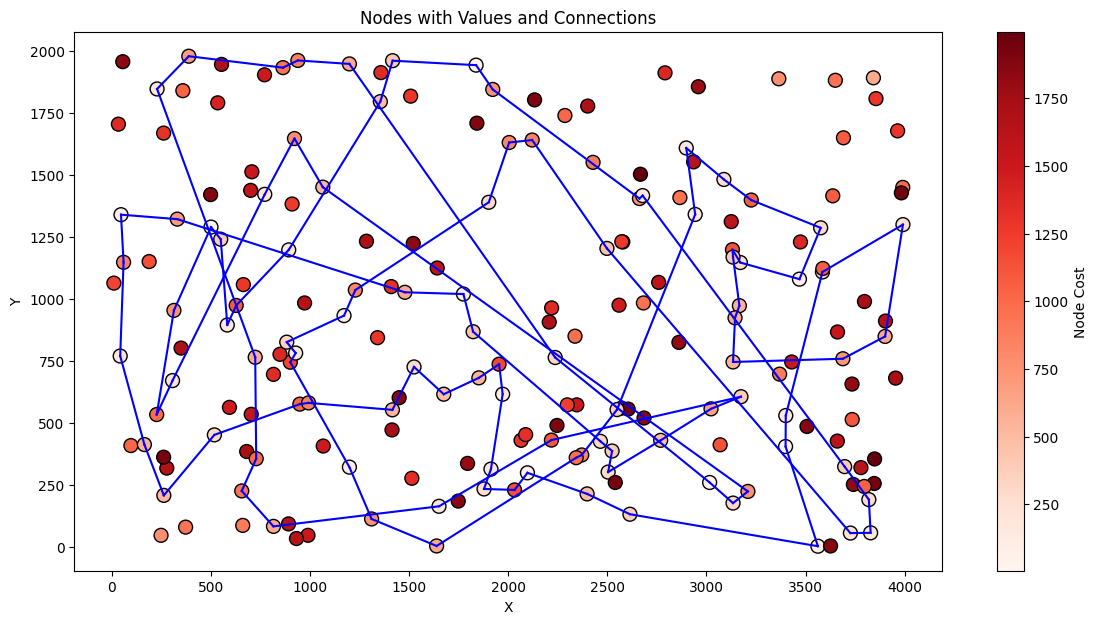

Acheived Total Score: 87896


In [13]:
def update_score_inner(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    if int(abs(cycle_position - any_node_position)) > 1 and int(abs(cycle_position - any_node_position)) < 99:
        node_1 = solution[cycle_position]
        node_2 = solution[any_node_position]
        node_before_1 = solution[cycle_position-1]
        if cycle_position + 1 == num_cycle_nodes:
            node_after_1 = solution[0]
        else:
            node_after_1 = solution[cycle_position+1]

        node_before_2 = solution[any_node_position-1]
        if any_node_position + 1 == num_cycle_nodes:
            node_after_2 = solution[0]
        else:
            node_after_2 = solution[any_node_position+1]

        temp_score -= distance_matrix[node_1][node_before_1]
        temp_score -= distance_matrix[node_1][node_after_1]
        temp_score -= distance_matrix[node_2][node_before_2]
        temp_score -= distance_matrix[node_2][node_after_2]
        temp_score += distance_matrix[node_1][node_before_2]
        temp_score += distance_matrix[node_1][node_after_2]
        temp_score += distance_matrix[node_2][node_before_1]
        temp_score += distance_matrix[node_2][node_after_1]
    else:
        if cycle_position < any_node_position:
            cycle_position, any_node_position = any_node_position, cycle_position
        node_1 = solution[cycle_position]
        node_2 = solution[any_node_position]
        if cycle_position + 1 == num_cycle_nodes and any_node_position + 2 == num_cycle_nodes:
            node_after_1 = solution[0]
        elif cycle_position + 1 == num_cycle_nodes and any_node_position == 0:
            node_after_1 = solution[cycle_position - 1]
        else:
            node_after_1 = solution[cycle_position + 1]
        
        if cycle_position + 1 == num_cycle_nodes and any_node_position == 0:
            node_before_2 = solution[any_node_position + 1]
        else:
            node_before_2 = solution[any_node_position - 1]
        temp_score -= distance_matrix[node_1][node_after_1]
        temp_score -= distance_matrix[node_2][node_before_2]
        temp_score += distance_matrix[node_1][node_before_2]
        temp_score += distance_matrix[node_2][node_after_1]
    return temp_score


def node_inter_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_inner(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    if temp_score < score:
        solution[cycle_position], solution[any_node_position] = solution[any_node_position], solution[cycle_position]
        score = temp_score
        improvement = True
    return score, improvement, solution

def update_score_intra(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    node_1 = solution[cycle_position]
    node_2 = remaining_nodes[relative_node_position]
    node_before = solution[cycle_position-1]
    if cycle_position + 1 == num_cycle_nodes:
        node_after = solution[0]
    else:
        node_after = solution[cycle_position+1]
    temp_score -= distance_matrix[node_1][node_before]
    temp_score -= distance_matrix[node_1][node_after]
    temp_score -= weights[node_1]
    temp_score += distance_matrix[node_2][node_before]
    temp_score += distance_matrix[node_2][node_after]
    temp_score += weights[node_2]
    return temp_score

def node_intra_change(score, improvement, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    temp_score = score
    relative_node_position = any_node_position - num_cycle_nodes
    temp_score = update_score_intra(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
    if temp_score < score:
        solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
        score = temp_score
        improvement = True
    return score, improvement, solution

def greedy_local_search(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    num_cycle_nodes = len(solution)
    moves = []
    for cycle_position in cycle_positions:
        for any_node in all_node_positions:
            if cycle_position != any_node:
                moves.append((cycle_position, any_node))
    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                score, improvement, solution = node_intra_change(score, improvement, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
            else:
                score, improvement, solution = node_inter_change(score, improvement, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
            if improvement:
                break
    return solution, score

solution, score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = greedy_local_search(solution, score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Steepest Local Search

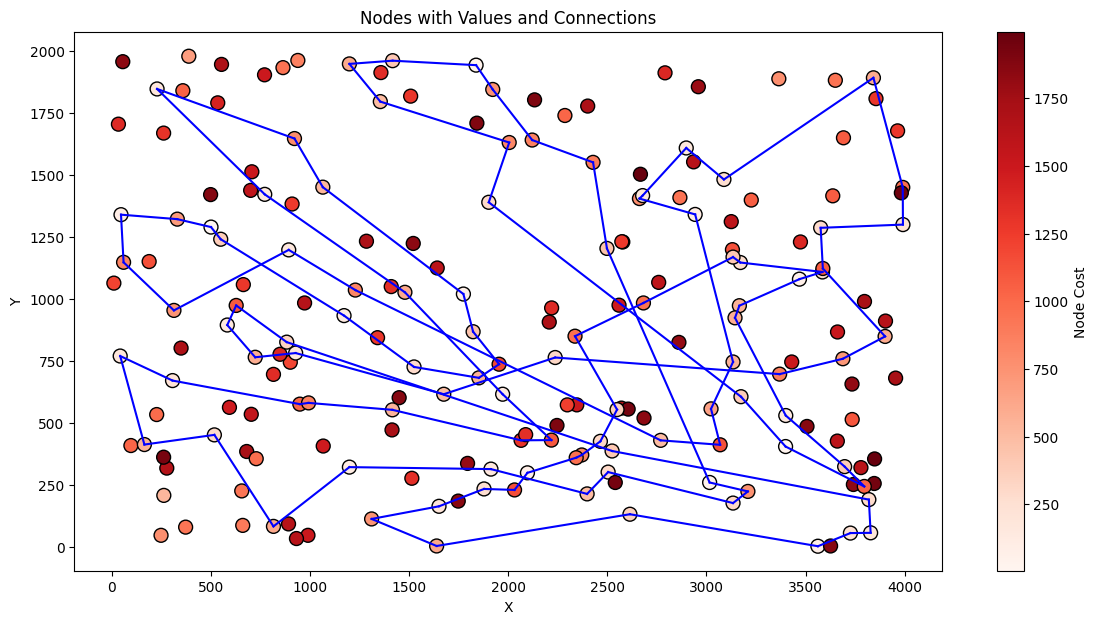

Acheived Total Score: 90139


In [14]:
def node_inter_change_steepest(score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix):
    temp_score = score
    temp_score = update_score_inner(temp_score, solution, cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
    solution[cycle_position], solution[any_node_position] = solution[any_node_position], solution[cycle_position]
    return temp_score, solution

def node_intra_change_steepest(score, solution, cycle_position, any_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights):
    temp_score = score
    relative_node_position = any_node_position - num_cycle_nodes
    temp_score = update_score_intra(temp_score, solution, cycle_position, relative_node_position, remaining_nodes, num_cycle_nodes, distance_matrix, weights)
    solution[cycle_position], remaining_nodes[relative_node_position] = remaining_nodes[relative_node_position], solution[cycle_position]
    return temp_score, solution, remaining_nodes

def steepest_local_search(solution, score, distance_matrix, weights):
    all_node_positions = [i for i in range(len(weights))]
    cycle_positions = [i for i in range(len(solution))]
    remaining_nodes = list(set(all_node_positions) - set(solution))
    num_cycle_nodes = len(solution)
    moves = []
    for cycle_position in cycle_positions:
        for any_node in all_node_positions:
            if cycle_position != any_node:
                moves.append((cycle_position, any_node))
    improvement = True
    while improvement:
        improvement = False
        random.shuffle(moves)
        best_score = np.inf
        best_solution = None
        best_remaining_nodes = remaining_nodes.copy()
        for cycle_position, any_node_position in moves:
            if any_node_position >= num_cycle_nodes:
                temp_score, temp_solution, temp_remaining_nodes = node_intra_change_steepest(score, solution.copy(), cycle_position, any_node_position, remaining_nodes.copy(), num_cycle_nodes, distance_matrix, weights)
            else:
                temp_score = score
                temp_solution = solution.copy()
                temp_score, temp_solution = node_inter_change_steepest(score, solution.copy(), cycle_position, any_node_position, num_cycle_nodes, distance_matrix)
                temp_remaining_nodes = remaining_nodes.copy()
            if temp_score < best_score:
                best_score = temp_score
                best_solution = temp_solution.copy()
                best_remaining_nodes = temp_remaining_nodes.copy()
        if best_score < score:
            score = best_score
            improvement = True
            solution = best_solution.copy()
            remaining_nodes = best_remaining_nodes.copy()
    return solution, score

solution, score = random_solution(distance_matrix, weights, start_node = 0)
solution, score = steepest_local_search(solution, score, distance_matrix, weights)
plot_nodes_with_lines(df, solution)
print(f"Acheived Total Score: {score}")

## Experiments

In [15]:
def test_algorithm(algorithm, distance_matrix, weights, local_algorithm = None):
    '''
    Tests chosen algorithm for each node.

    Parameters:
    local_algorithm: function of the local search
    algorithm: Function to test
    distance_matrix: numpy.array containing distances between nodes.
    weights: numpy.array containing the weights associated with each node.
    num_runs: integer, number of tests per node (default: 200)
    '''
    all_nodes = [i for i in range(len(weights))]
    results = {}
    intermidiate_results = {}
    solutions = {}
    times = []
    for node in all_nodes:
        solution, score = algorithm(distance_matrix, weights, node)
        intermidiate_results[node] = score
        if local_algorithm is not None:
            start_time = time.time()
            solution, score = local_algorithm(solution, score, distance_matrix, weights)
            end_time = time.time()
            times.append(end_time - start_time)
        solutions[node] = solution
        results[node] = score
    return solutions, intermidiate_results, results, times

In [16]:
del df
del weights
del distance_matrix

### Instance A

In [17]:
df_A = pd.read_csv(TSPA_PATH, sep=";", header=None)
df_A.columns = ["x", "y", "val"]
distance_matrix_A = get_distance_matrix(df_A, euclidean_distance)
weights_A = df_A.val.to_numpy()

In [18]:
random_greedy_local_solution_A, random_greedy_local_intermidiate_A, random_greedy_local_result_A, random_greedy_local_times_A = test_algorithm(random_solution, distance_matrix_A, weights_A, local_algorithm = greedy_local_search)

In [19]:
random_steepest_solution_A, random_steepest_intermidiate_A, random_steepest_result_A, random_steepest_times_A = test_algorithm(random_solution, distance_matrix_A, weights_A, local_algorithm = steepest_local_search)

In [20]:
weighted_greedy_local_solution_A, weighted_greedy_local_intermidiate_A, weighted_greedy_local_result_A, weighted_greedy_local_times_A = test_algorithm(greedy_regret_cycle_weighted, distance_matrix_A, weights_A, local_algorithm = greedy_local_search)

In [21]:
weighted_steepest_solution_A, weighted_steepest_intermidiate_A, weighted_steepest_result_A, weighted_steepest_times_A = test_algorithm(greedy_regret_cycle_weighted, distance_matrix_A, weights_A, local_algorithm = steepest_local_search)

### Instance B

In [22]:
df_B = pd.read_csv(TSPB_PATH, sep=";", header=None)
df_B.columns = ["x", "y", "val"]
distance_matrix_B = get_distance_matrix(df_B, euclidean_distance)
weights_B = df_B.val.to_numpy()

In [23]:
random_greedy_local_solution_B, random_greedy_local_intermidiate_B, random_greedy_local_result_B, random_greedy_local_times_B = test_algorithm(random_solution, distance_matrix_B, weights_B, local_algorithm = greedy_local_search)

In [24]:
random_steepest_solution_B, random_steepest_intermidiate_B, random_steepest_result_B, random_steepest_times_B = test_algorithm(random_solution, distance_matrix_B, weights_B, local_algorithm = steepest_local_search)

In [25]:
nn_greedy_local_solution_B, nn_greedy_local_intermidiate_B, nn_greedy_local_result_B, nn_greedy_local_times_B = test_algorithm(nearest_neighbor_all, distance_matrix_B, weights_B, local_algorithm = greedy_local_search)

In [26]:
nn_steepest_solution_B, nn_steepest_intermidiate_B, nn_steepest_result_B, nn_steepest_times_B = test_algorithm(nearest_neighbor_all, distance_matrix_B, weights_B, local_algorithm = steepest_local_search)

## Results - Instance A

In [27]:
def plot_nodes_with_lines_and_score(df, score, connections=None):
    """
    Plots nodes with optional lines connecting them, using a color scale to represent values.
    
    Parameters:
    df: DataFrame of nodes, each with 'x', 'y', and 'val'.
    connections: list of node indices in the DataFrame to connect in order.
    """
    plt.figure(figsize=(14, 7))
    norm = plt.Normalize(vmin=df.val.min(), vmax=df.val.max())
    colors = cm.Reds(norm(df.val))
    scatter = plt.scatter(df.x, df.y, c=df.val, cmap='Reds', s=100, edgecolors='black')

    if connections is not None:
        for start, end in zip(connections[:-1], connections[1:]):
            plt.plot([df.x[start], df.x[end]], [df.y[start], df.y[end]], color='blue')
        plt.plot([df.x[connections[-1]], df.x[connections[0]]], [df.y[connections[-1]], df.y[connections[0]]], color='blue')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Node Cost')

    plt.xlabel('X')
    plt.ylabel('Y')
    title = f'Nodes with Color-Scaled Values, Score: {score}' if connections is None else f'Nodes with Color-Scaled Values, Score: {score}'
    plt.title(title)
    plt.grid(False)
    plt.show()

def plot_score_distribution(score_dict, label, title, x_label):
    all_scores = []
    if type(score_dict) == dict:
        for key in score_dict.keys():
            item = score_dict[key]
            all_scores.append(item)
    else:
        all_scores = score_dict
    plt.hist(all_scores, bins=30, density=True, edgecolor='black', color="black", alpha=0.7)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Relative Frequency')
    plt.show()

def plot_score_distributions(score_dict_1, score_dict_2, labels, title = 'Continuous Distribution of Scores Across Different Nodes', x_label = 'Score Value'):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(all_scores_1, label=labels[0], color='black', linewidth=2)
    sns.kdeplot(all_scores_2, label=labels[1], color='red', linewidth=2)
    plt.xscale('log')
    
    # Add titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(loc='upper right')
    plt.show()

In [28]:
def plot_best_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmin(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)

def plot_average_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)

    all_scores = np.array(all_scores)
    median_index = np.argsort(all_scores)[len(all_scores) // 2]
    median_solution = all_solutions[median_index]
    
    print("___________________________________________________________________")
    print(f"For Node: {median_index}")
    plot_nodes_with_lines_and_score(df, all_scores[median_index], median_solution)

def plot_worst_overall(df, solutions, results):
    all_scores = []
    for key in results.keys():
        item = results[key]    
        all_scores.append(item)
    
    all_solutions = []
    for key in solutions.keys():
        item = solutions[key]
        all_solutions.append(item)
    
    all_scores = np.array(all_scores)
    best_overall = np.argmax(all_scores)
    best_solution = all_solutions[best_overall]
    print("___________________________________________________________________")
    print(f"For Node: {best_overall}")
    plot_nodes_with_lines_and_score(df, all_scores[best_overall], best_solution)


def calculate_stats_overall(results):
    all_scores = []
    if type(results) == dict:
        for key in results.keys():
            all_scores.append(results[key])
    else:
        all_scores = results
    all_scores = np.array(all_scores)
    min_value = np.min(all_scores)
    max_value = np.max(all_scores)
    median_value = np.median(all_scores)
    mean_value = np.mean(all_scores)
    std_deviation = np.std(all_scores)
    return min_value, max_value, median_value, mean_value, std_deviation


def plot_node(df, scores, solutions, node):
    score = scores[node]
    connections = solutions[node]
    print(f"Plotting Node: {node}")
    plot_nodes_with_lines_and_score(df, score, connections)

def compare_improvement(result, improved_result):
    initial_results = []
    improved_results = []
    for key in result:
        val = result[key]
        initial_results.append(val)
        val = improved_result[key]
        improved_results.append(val)
    initial_arr = np.array(initial_results)
    improved_arr = np.array(improved_results)
    differences = initial_arr - improved_arr
    min_val = np.min(differences)
    max_val = np.max(differences)
    mean = np.mean(differences)
    median = np.median(differences)
    std = np.std(differences)
    relative = np.mean(differences/initial_arr)
    return min_val, max_val, mean, median, std, relative

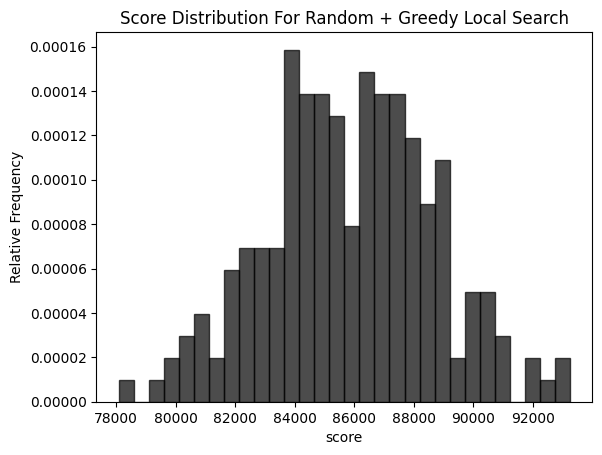

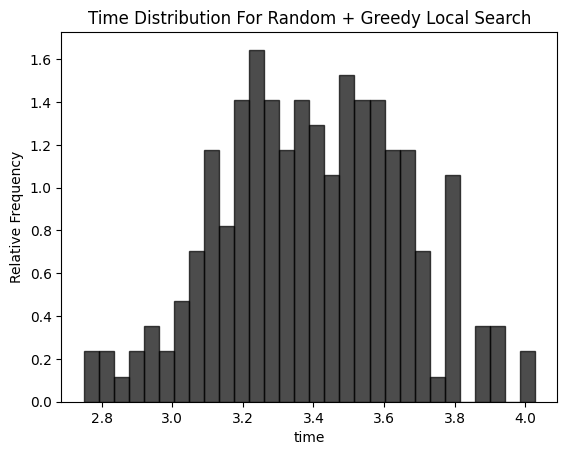

___________________________________________________________________
For Node: 12


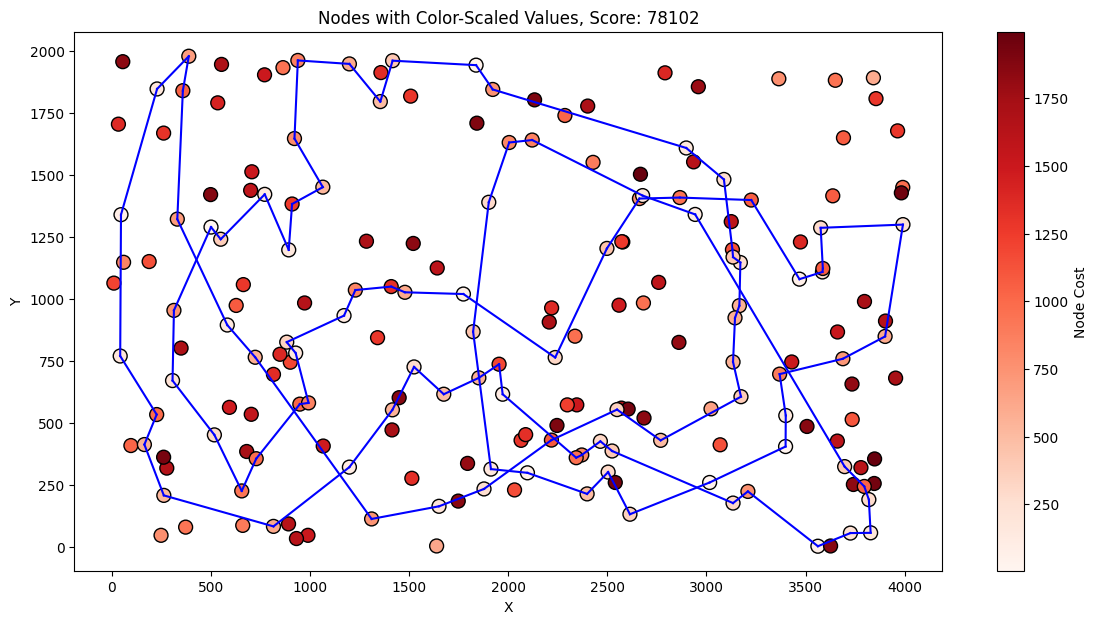

___________________________________________________________________
For Node: 157


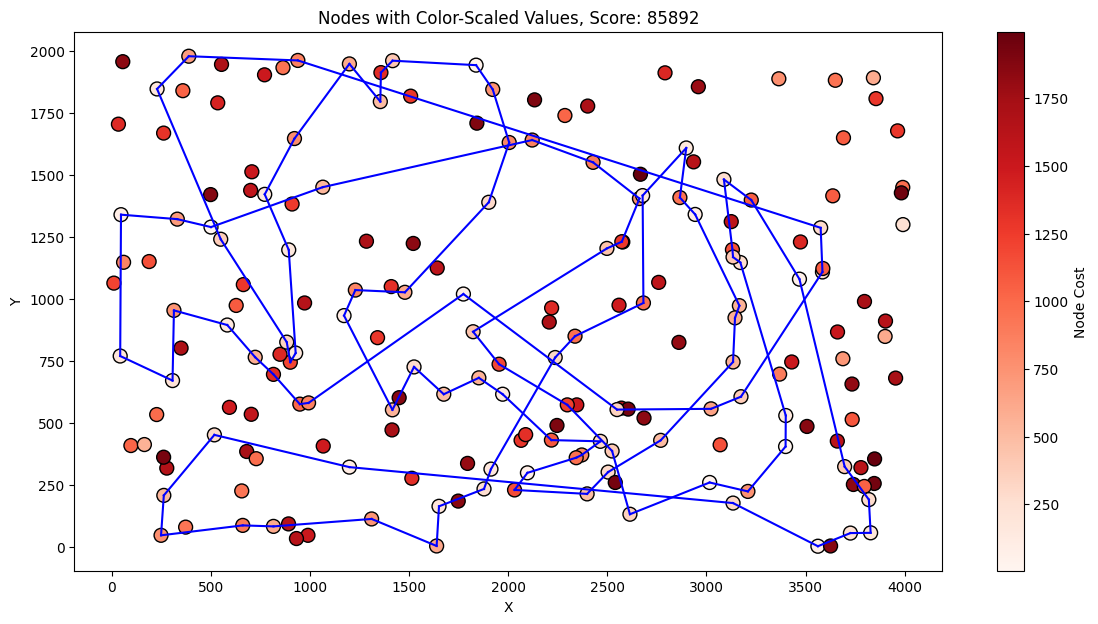

___________________________________________________________________
For Node: 191


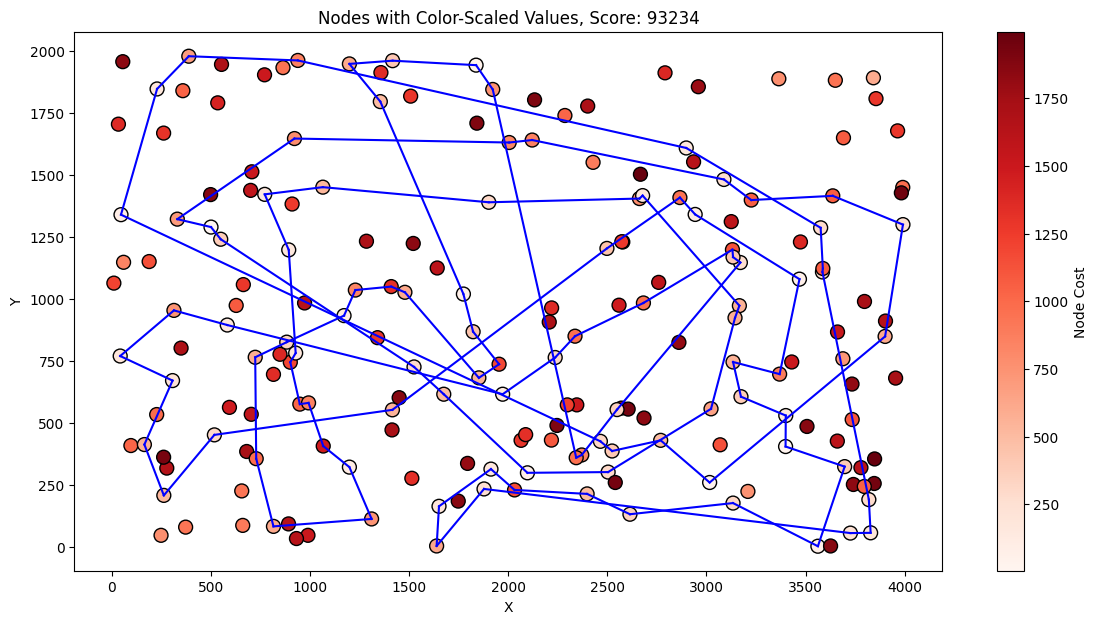

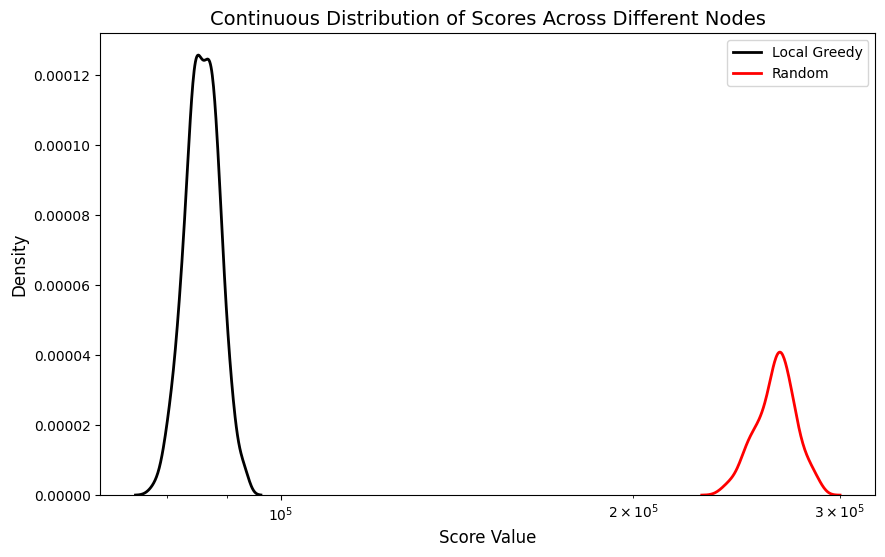

Overall Stats: 
 Minimum: 78102 Maximum: 93234 Median: 85851.5 Mean: 85857.735 Standard Deviation: 2819.259898408623
Time Stats: 
 Minimum: 2.750032663345337 Maximum: 4.0270044803619385 Median: 3.3920013904571533 Mean: 3.3955103743076323 Standard Deviation: 0.25560680530248914
Comparison Stats: 
 Minimum: 150727 Maximum: 150727 Median: 179647.0 Mean: 179345.485 Standard Deviation: 10356.689109448782 and Relative: 0.6758042054128128


In [29]:
plot_score_distribution(random_greedy_local_result_A, label="Random + Greedy Local Search", title = "Score Distribution For Random + Greedy Local Search", x_label = "score")
plot_score_distribution(random_greedy_local_times_A, label="Times Random + Greedy Local Search", title = "Time Distribution For Random + Greedy Local Search", x_label = "time")
plot_best_overall(df_A, random_greedy_local_solution_A, random_greedy_local_result_A)
plot_average_overall(df_A, random_greedy_local_solution_A, random_greedy_local_result_A)
plot_worst_overall(df_A, random_greedy_local_solution_A, random_greedy_local_result_A)
plot_score_distributions(random_greedy_local_result_A, random_greedy_local_intermidiate_A, labels = ["Local Greedy", "Random"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(random_greedy_local_result_A)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(random_greedy_local_times_A)
min_val, max_val, mean, median, std, relative = compare_improvement(random_greedy_local_intermidiate_A, random_greedy_local_result_A)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

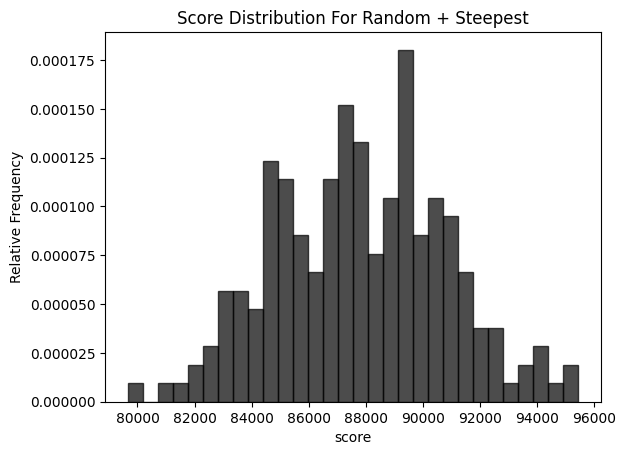

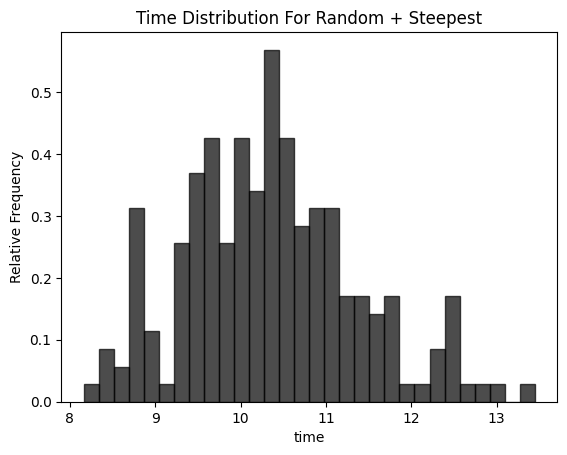

___________________________________________________________________
For Node: 32


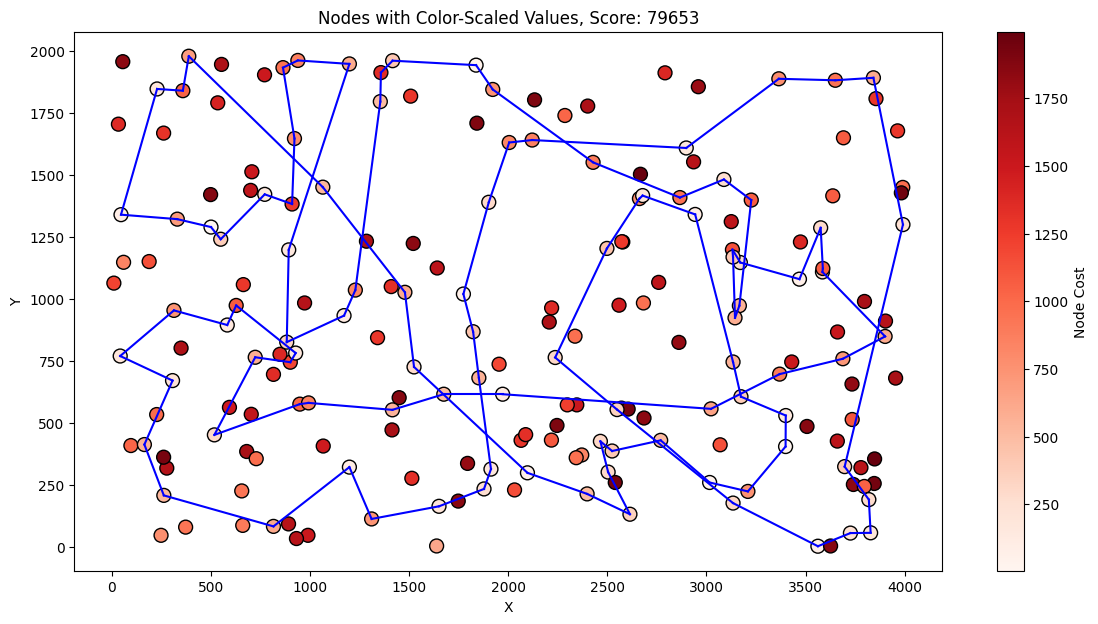

___________________________________________________________________
For Node: 198


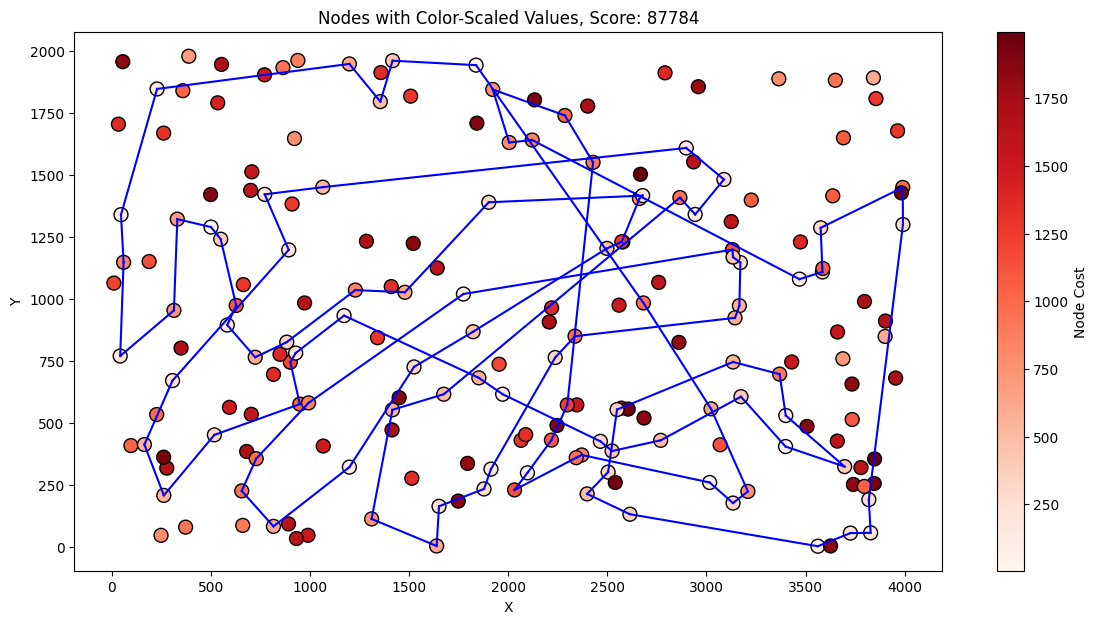

___________________________________________________________________
For Node: 54


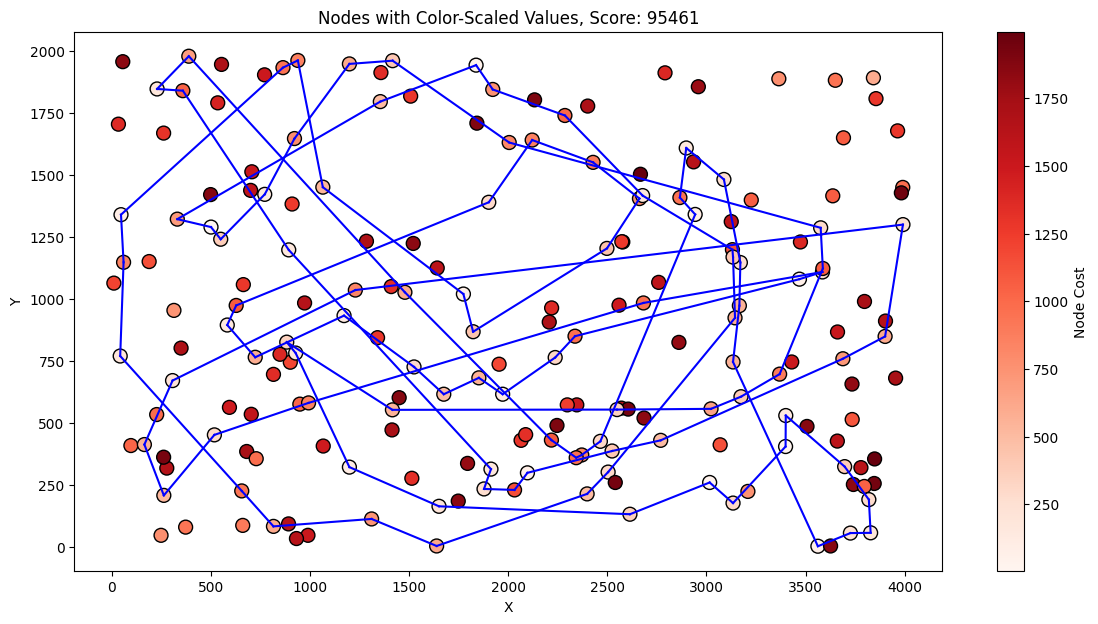

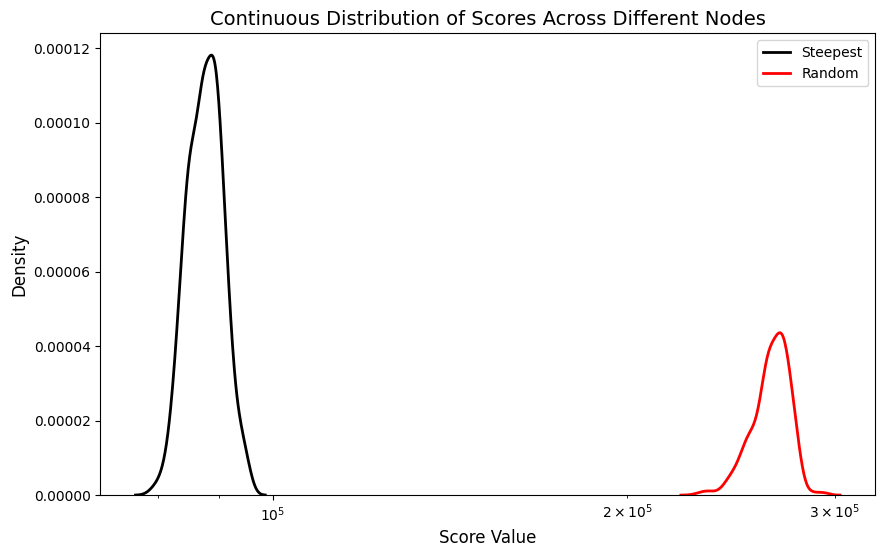

Overall Stats: 
 Minimum: 79653 Maximum: 95461 Median: 87776.0 Mean: 87813.05 Standard Deviation: 3004.4179382203138
Time Stats: 
 Minimum: 8.165000677108765 Maximum: 13.446000814437866 Median: 10.306499242782593 Mean: 10.356054710149765 Standard Deviation: 1.00704201422756
Comparison Stats: 
 Minimum: 141625 Maximum: 141625 Median: 178456.5 Mean: 177520.85 Standard Deviation: 10348.588341290806 and Relative: 0.6685478374785242


In [30]:
plot_score_distribution(random_steepest_result_A, label="Random + Steepest", title = "Score Distribution For Random + Steepest", x_label = "score")
plot_score_distribution(random_steepest_times_A, label="Times Random + Steepest", title = "Time Distribution For Random + Steepest", x_label = "time")
plot_best_overall(df_A, random_steepest_solution_A, random_steepest_result_A)
plot_average_overall(df_A, random_steepest_solution_A, random_steepest_result_A)
plot_worst_overall(df_A, random_steepest_solution_A, random_steepest_result_A)
plot_score_distributions(random_steepest_result_A, random_steepest_intermidiate_A, labels = ["Steepest", "Random"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(random_steepest_result_A)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(random_steepest_times_A)
min_val, max_val, mean, median, std, relative = compare_improvement(random_steepest_intermidiate_A, random_steepest_result_A)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

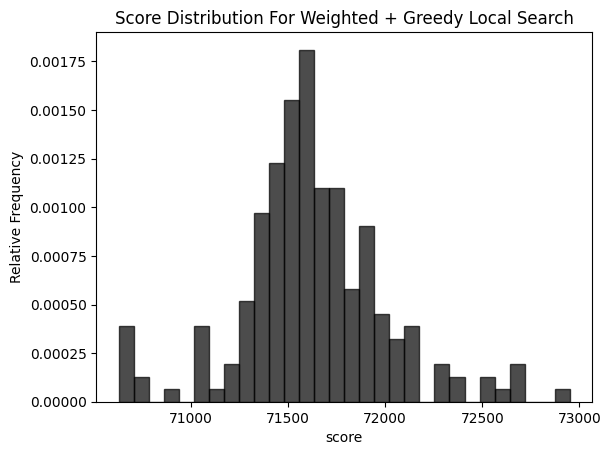

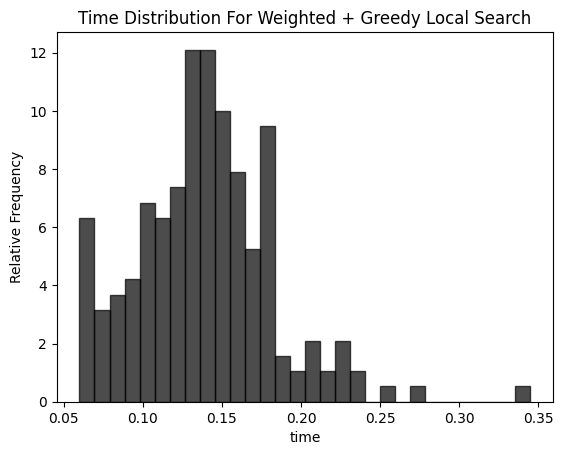

___________________________________________________________________
For Node: 153


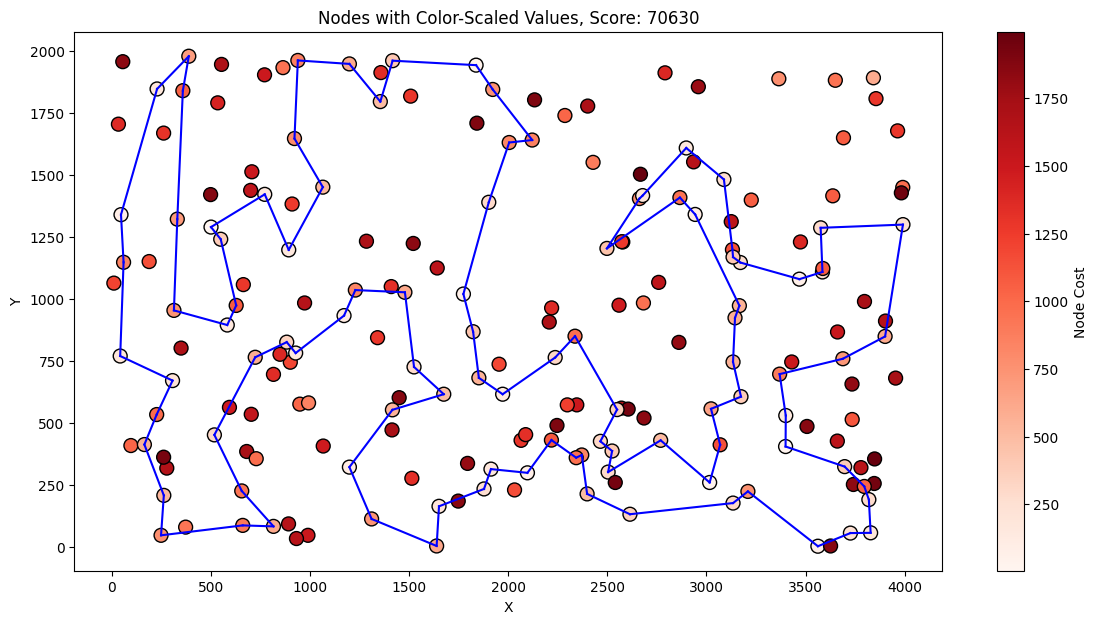

___________________________________________________________________
For Node: 177


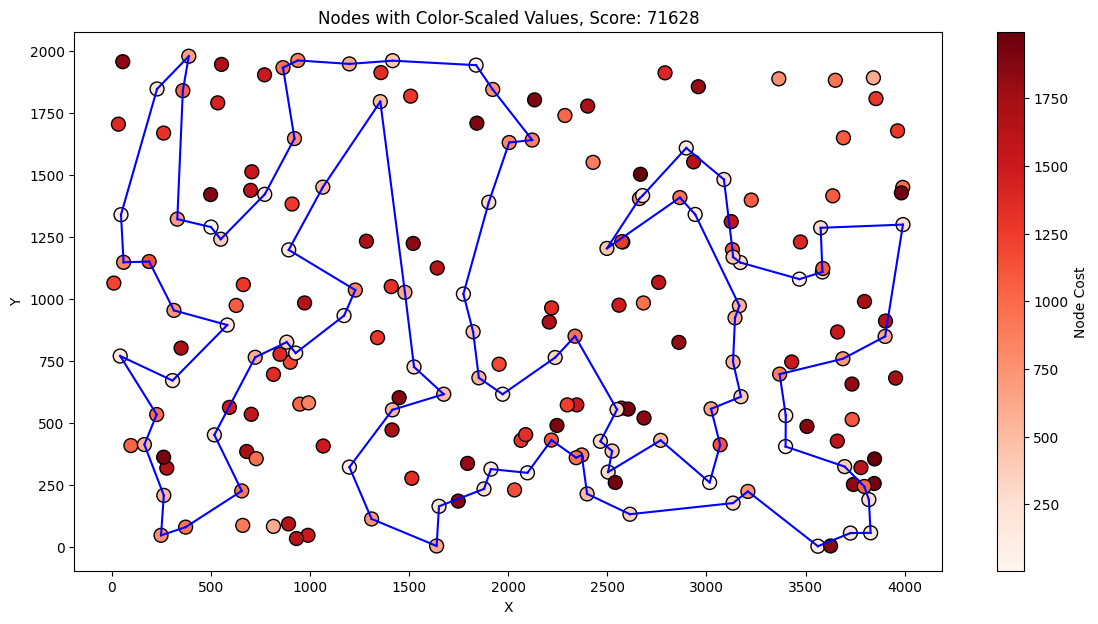

___________________________________________________________________
For Node: 125


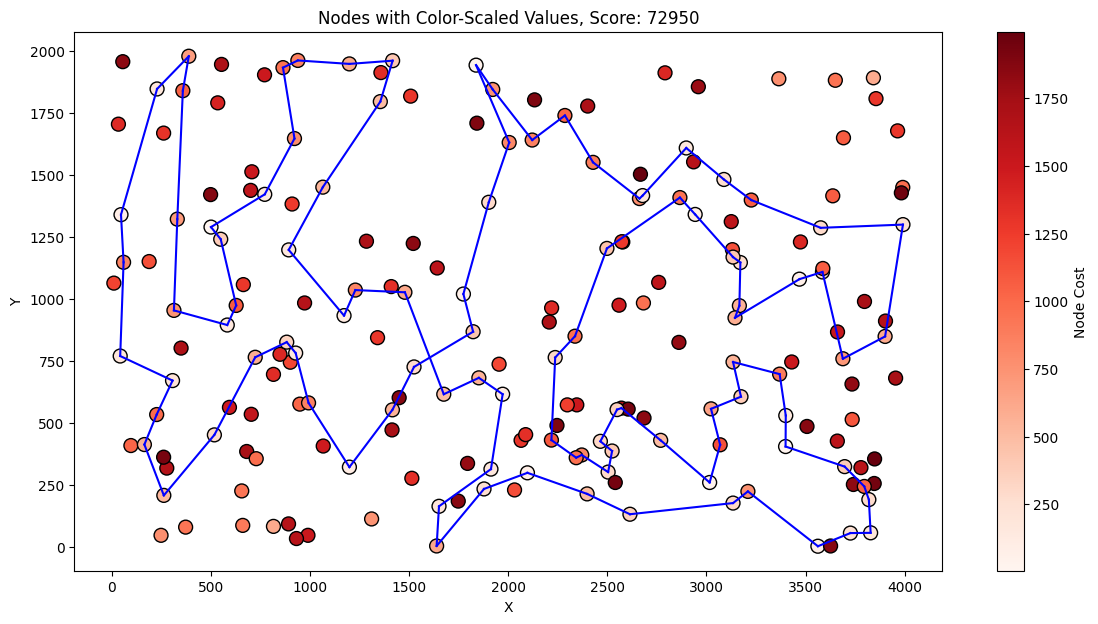

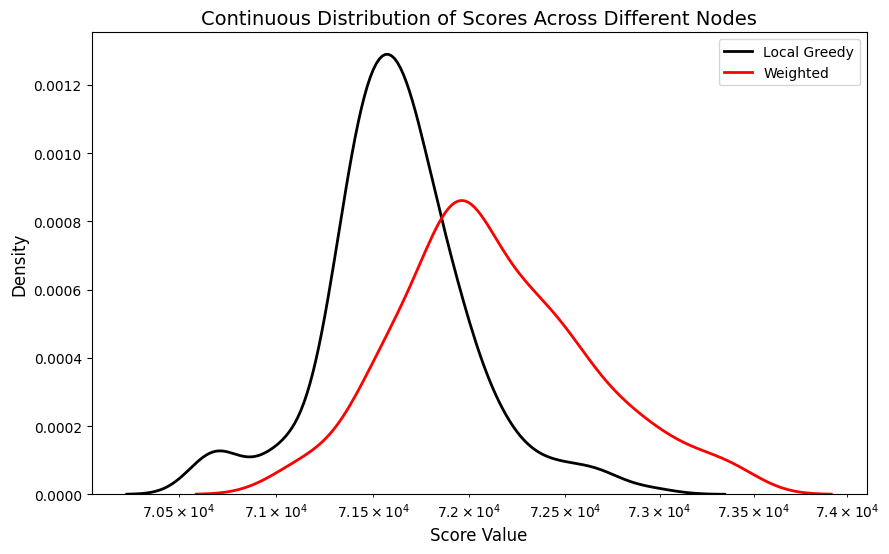

Overall Stats: 
 Minimum: 70630 Maximum: 72950 Median: 71628.0 Mean: 71627.345 Standard Deviation: 379.3764963397179
Time Stats: 
 Minimum: 0.05999898910522461 Maximum: 0.3449995517730713 Median: 0.13899993896484375 Mean: 0.13917413234710693 Standard Deviation: 0.04321192581945167
Comparison Stats: 
 Minimum: 7 Maximum: 7 Median: 458.0 Mean: 505.44 Standard Deviation: 343.1896362071559 and Relative: 0.006986226686194694


In [31]:
plot_score_distribution(weighted_greedy_local_result_A, label="Weighted + Greedy Local Search", title = "Score Distribution For Weighted + Greedy Local Search", x_label = "score")
plot_score_distribution(weighted_greedy_local_times_A, label="Times Weighted + Greedy Local Search", title = "Time Distribution For Weighted + Greedy Local Search", x_label = "time")
plot_best_overall(df_A, weighted_greedy_local_solution_A, weighted_greedy_local_result_A)
plot_average_overall(df_A, weighted_greedy_local_solution_A, weighted_greedy_local_result_A)
plot_worst_overall(df_A, weighted_greedy_local_solution_A, weighted_greedy_local_result_A)
plot_score_distributions(weighted_greedy_local_result_A, weighted_greedy_local_intermidiate_A, labels = ["Local Greedy", "Weighted"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(weighted_greedy_local_result_A)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(weighted_greedy_local_times_A)
min_val, max_val, mean, median, std, relative = compare_improvement(weighted_greedy_local_intermidiate_A, weighted_greedy_local_result_A)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

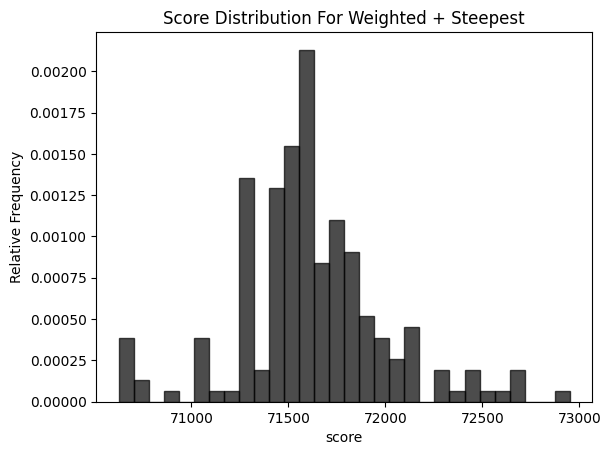

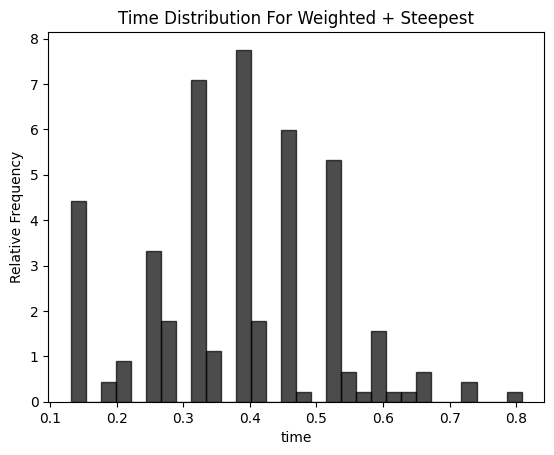

___________________________________________________________________
For Node: 153


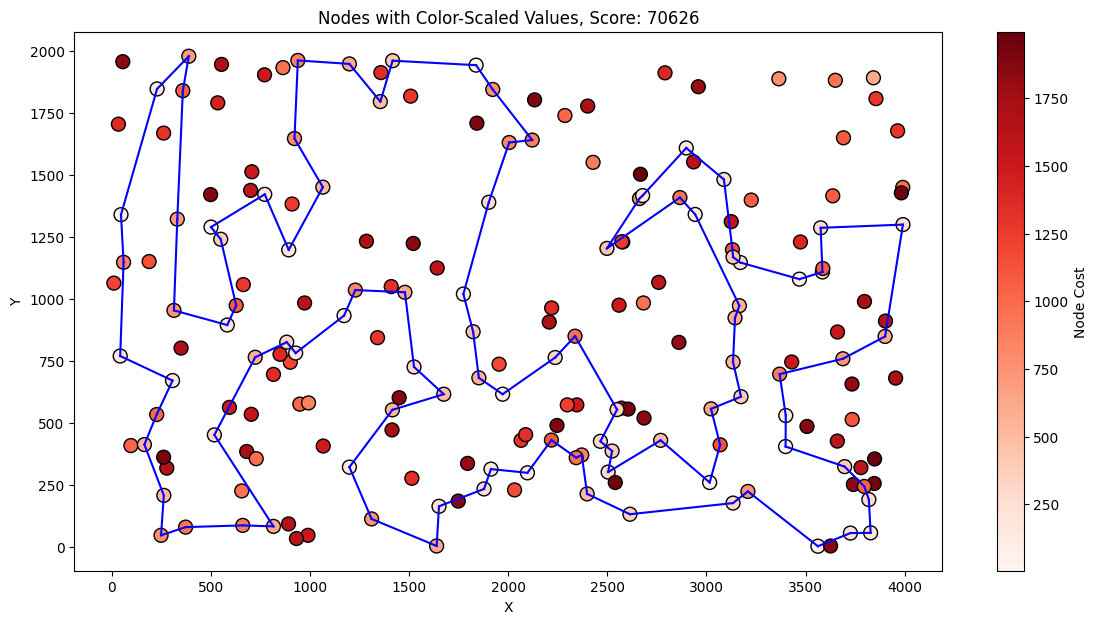

___________________________________________________________________
For Node: 54


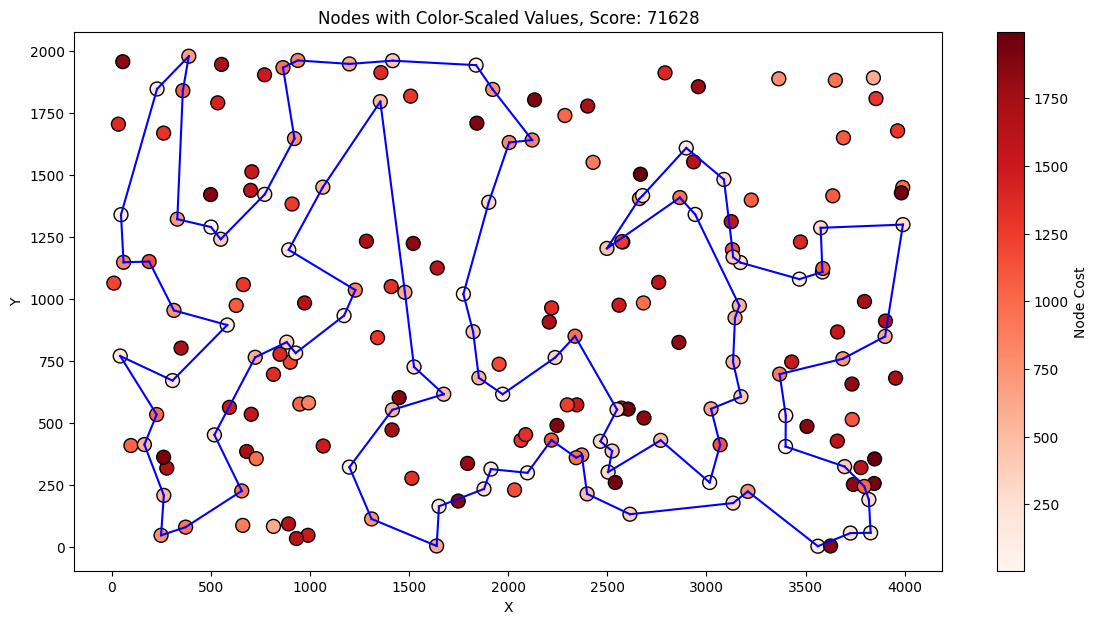

___________________________________________________________________
For Node: 125


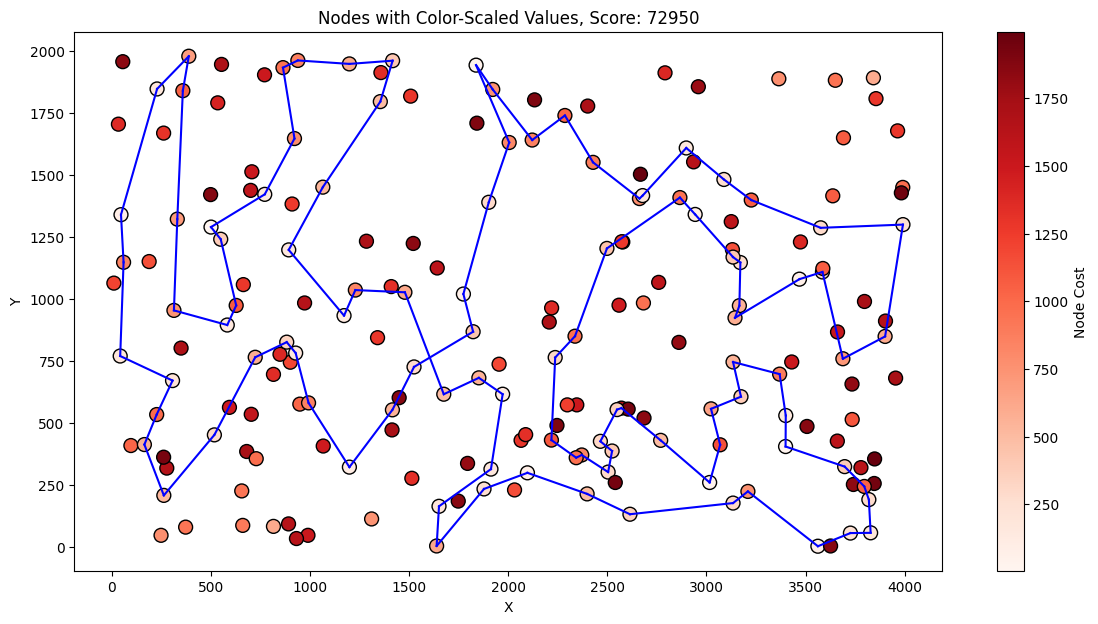

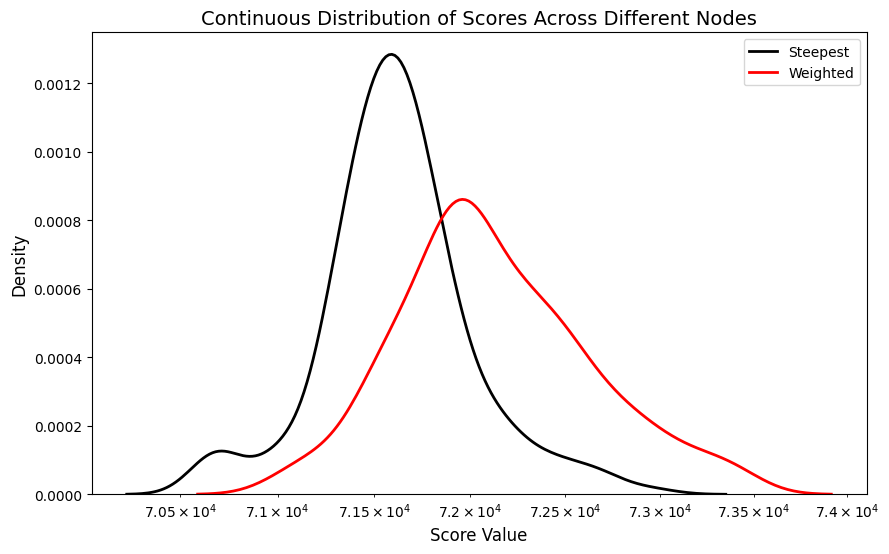

Overall Stats: 
 Minimum: 70626 Maximum: 72950 Median: 71628.0 Mean: 71621.67 Standard Deviation: 383.2167286275483
Time Stats: 
 Minimum: 0.13100171089172363 Maximum: 0.8079900741577148 Median: 0.393978476524353 Mean: 0.3833154082298279 Standard Deviation: 0.1364086660658633
Comparison Stats: 
 Minimum: 7 Maximum: 7 Median: 462.0 Mean: 511.115 Standard Deviation: 318.0497630481746 and Relative: 0.007066766479255202


In [32]:
plot_score_distribution(weighted_steepest_result_A, label="Weighted + Steepest", title = "Score Distribution For Weighted + Steepest", x_label = "score")
plot_score_distribution(weighted_steepest_times_A, label="Times Weighted + Steepest", title = "Time Distribution For Weighted + Steepest", x_label = "time")
plot_best_overall(df_A, weighted_steepest_solution_A, weighted_steepest_result_A)
plot_average_overall(df_A, weighted_steepest_solution_A, weighted_steepest_result_A)
plot_worst_overall(df_A, weighted_steepest_solution_A, weighted_steepest_result_A)
plot_score_distributions(weighted_steepest_result_A, weighted_steepest_intermidiate_A, labels = ["Steepest", "Weighted"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(weighted_steepest_result_A)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(weighted_steepest_times_A)
min_val, max_val, mean, median, std, relative = compare_improvement(weighted_steepest_intermidiate_A, weighted_steepest_result_A)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

## Results - Instance B

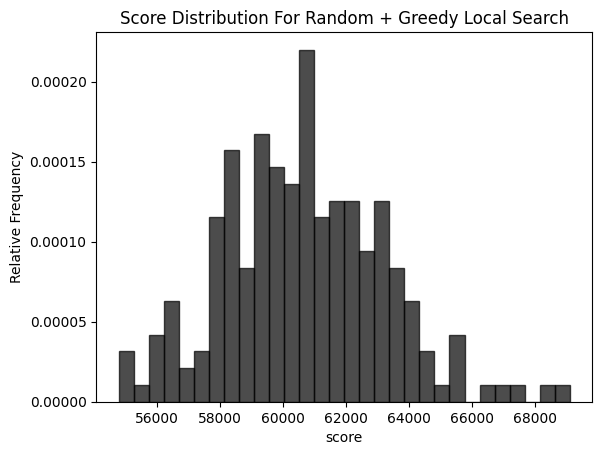

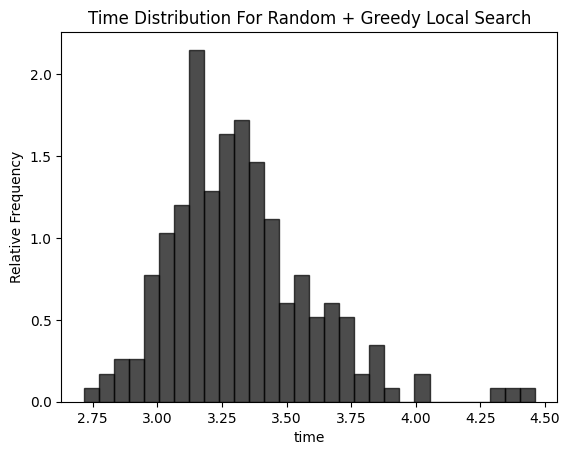

___________________________________________________________________
For Node: 193


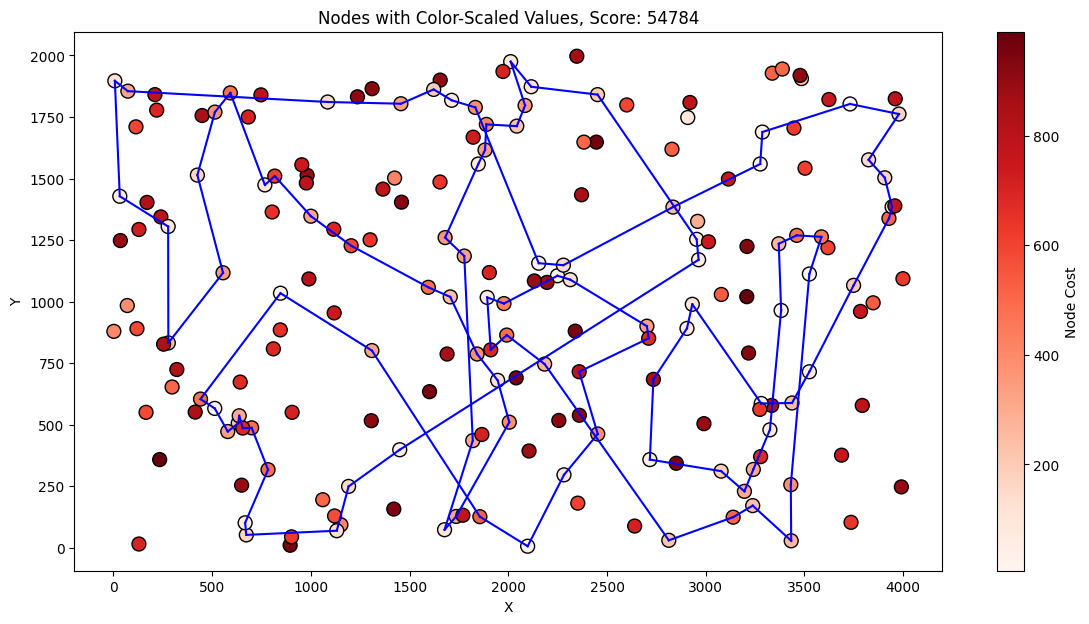

___________________________________________________________________
For Node: 114


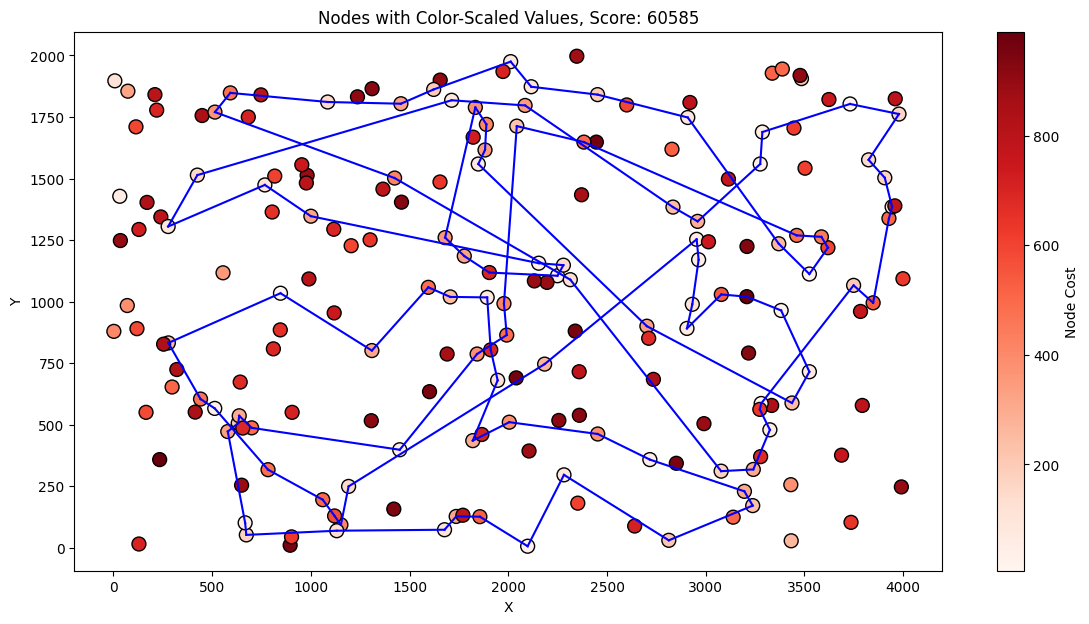

___________________________________________________________________
For Node: 48


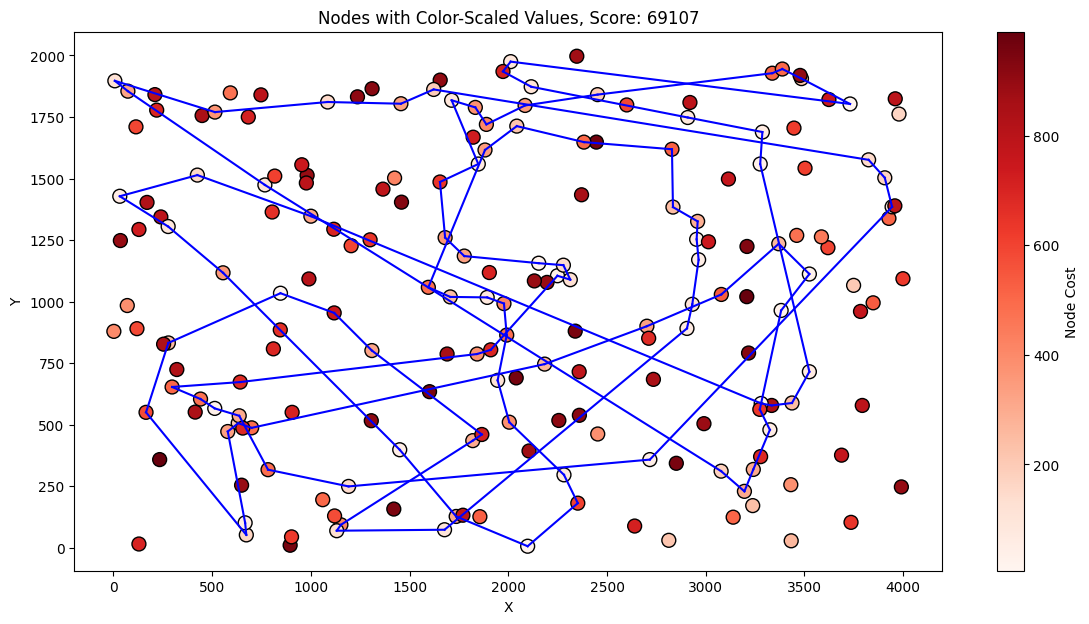

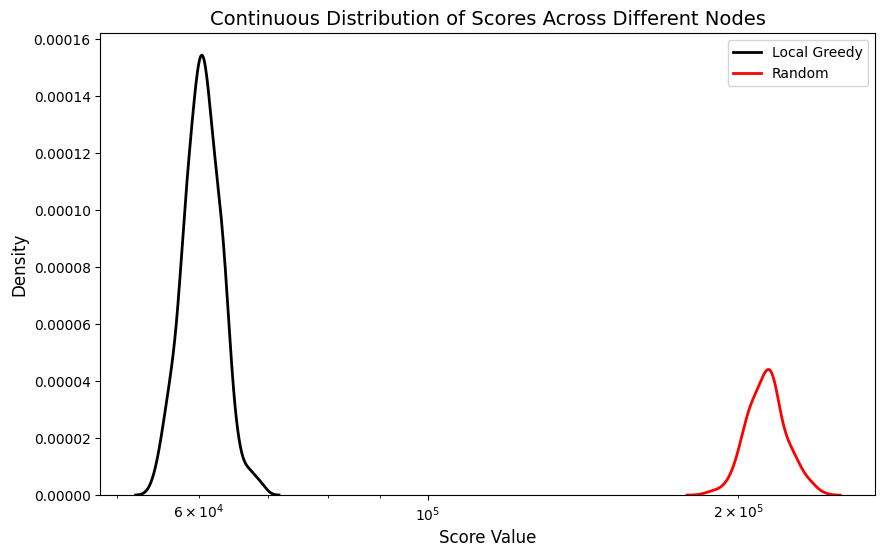

Overall Stats: 
 Minimum: 54784 Maximum: 69107 Median: 60559.0 Mean: 60650.07 Standard Deviation: 2552.8963169506123
Time Stats: 
 Minimum: 2.7160353660583496 Maximum: 4.459961414337158 Median: 3.284988045692444 Mean: 3.324110507965088 Standard Deviation: 0.278802172630931
Comparison Stats: 
 Minimum: 124952 Maximum: 124952 Median: 152488.5 Mean: 152824.44 Standard Deviation: 10006.02198460507 and Relative: 0.7152739449595651


In [33]:
plot_score_distribution(random_greedy_local_result_B, label="Random + Greedy Local Search", title = "Score Distribution For Random + Greedy Local Search", x_label = "score")
plot_score_distribution(random_greedy_local_times_B, label="Times Random + Greedy Local Search", title = "Time Distribution For Random + Greedy Local Search", x_label = "time")
plot_best_overall(df_B, random_greedy_local_solution_B, random_greedy_local_result_B)
plot_average_overall(df_B, random_greedy_local_solution_B, random_greedy_local_result_B)
plot_worst_overall(df_B, random_greedy_local_solution_B, random_greedy_local_result_B)
plot_score_distributions(random_greedy_local_result_B, random_greedy_local_intermidiate_B, labels = ["Local Greedy", "Random"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(random_greedy_local_result_B)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(random_greedy_local_times_B)
min_val, max_val, mean, median, std, relative = compare_improvement(random_greedy_local_intermidiate_B, random_greedy_local_result_B)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

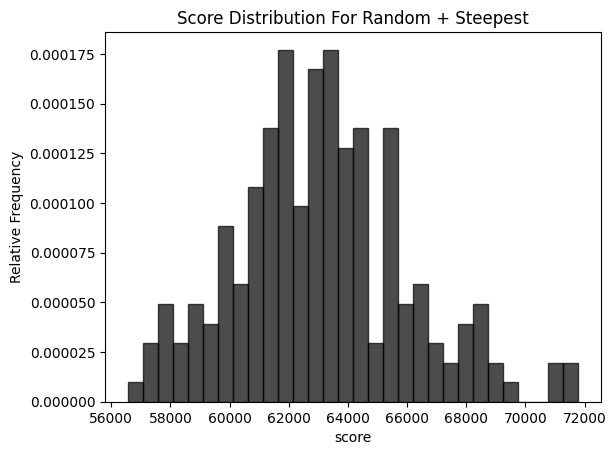

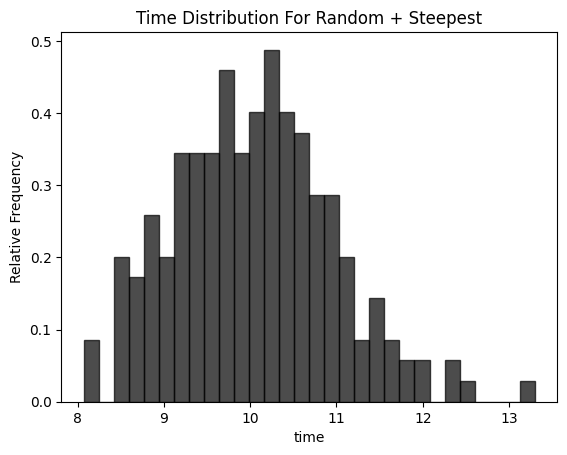

___________________________________________________________________
For Node: 21


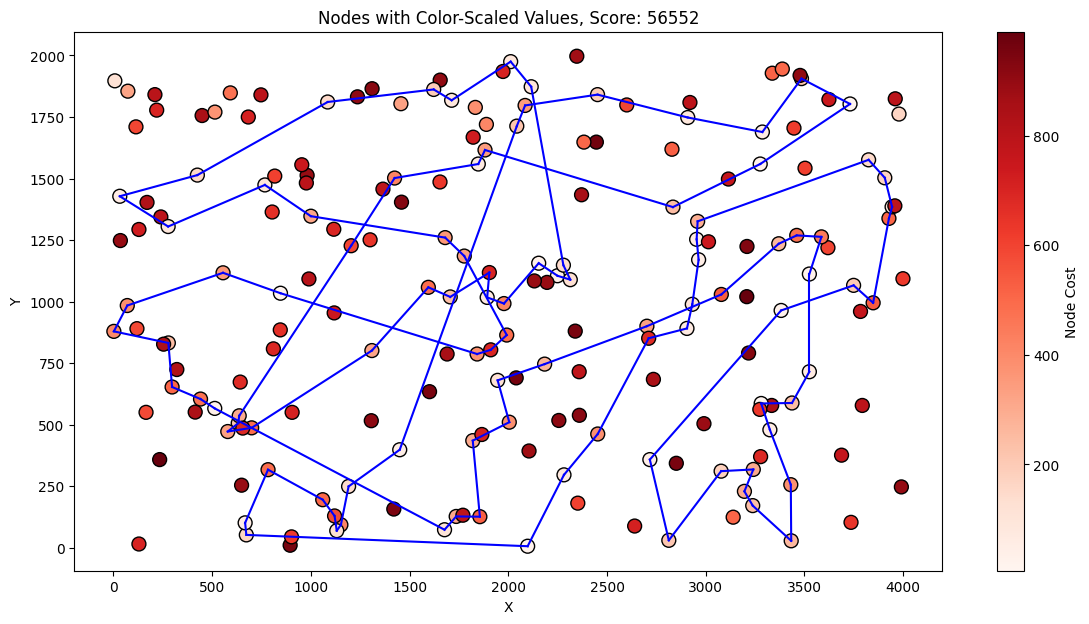

___________________________________________________________________
For Node: 25


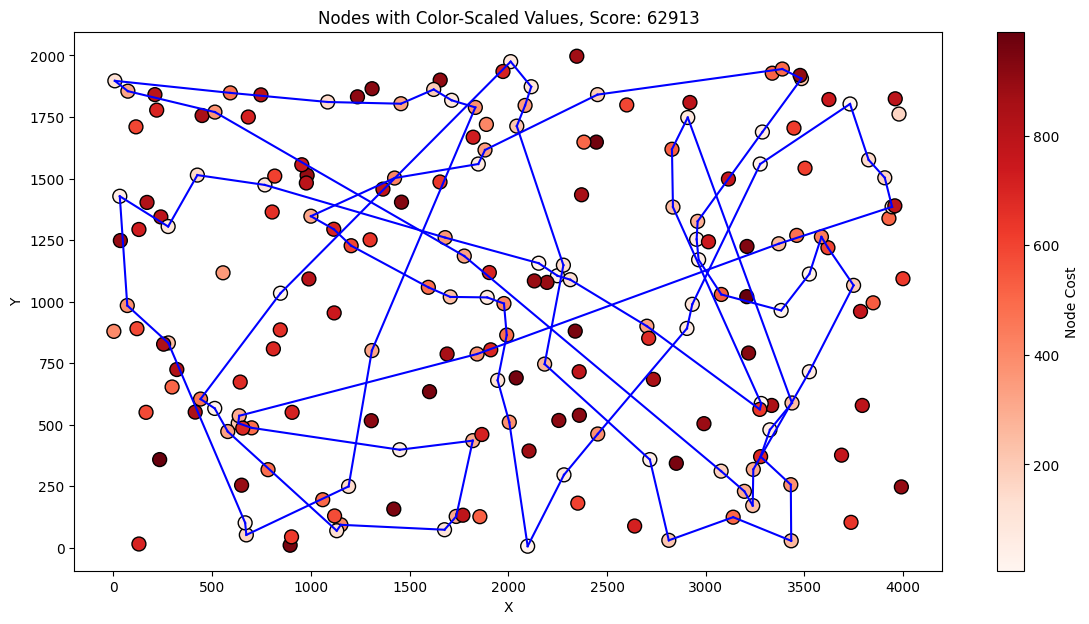

___________________________________________________________________
For Node: 107


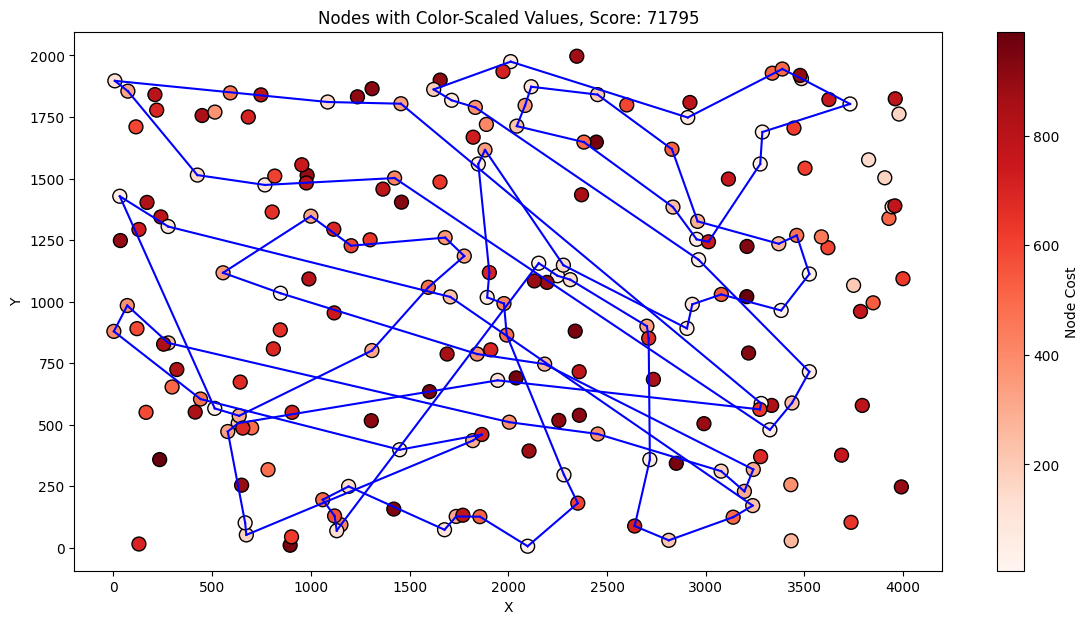

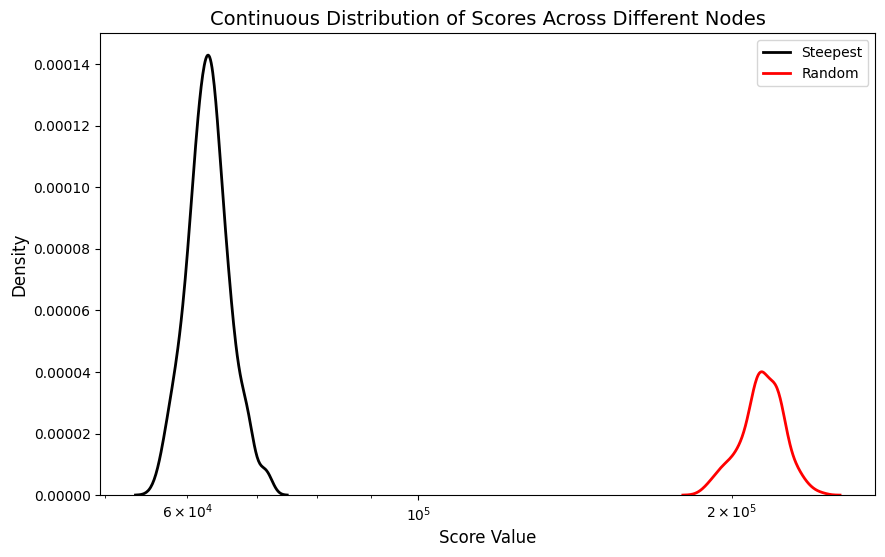

Overall Stats: 
 Minimum: 56552 Maximum: 71795 Median: 62895.0 Mean: 63092.675 Standard Deviation: 2923.913699029949
Time Stats: 
 Minimum: 8.072999000549316 Maximum: 13.297033786773682 Median: 10.058982729911804 Mean: 10.047714767456055 Standard Deviation: 0.9182250009921988
Comparison Stats: 
 Minimum: 123824 Maximum: 123824 Median: 152396.0 Mean: 151599.54 Standard Deviation: 10280.501462399585 and Relative: 0.7055145446605832


In [34]:
plot_score_distribution(random_steepest_result_B, label="Random + Steepest", title = "Score Distribution For Random + Steepest", x_label = "score")
plot_score_distribution(random_steepest_times_B, label="Times Random + Steepest", title = "Time Distribution For Random + Steepest", x_label = "time")
plot_best_overall(df_B, random_steepest_solution_B, random_steepest_result_B)
plot_average_overall(df_B, random_steepest_solution_B, random_steepest_result_B)
plot_worst_overall(df_B, random_steepest_solution_B, random_steepest_result_B)
plot_score_distributions(random_steepest_result_B, random_steepest_intermidiate_B, labels = ["Steepest", "Random"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(random_steepest_result_B)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(random_steepest_times_B)
min_val, max_val, mean, median, std, relative = compare_improvement(random_steepest_intermidiate_B, random_steepest_result_B)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

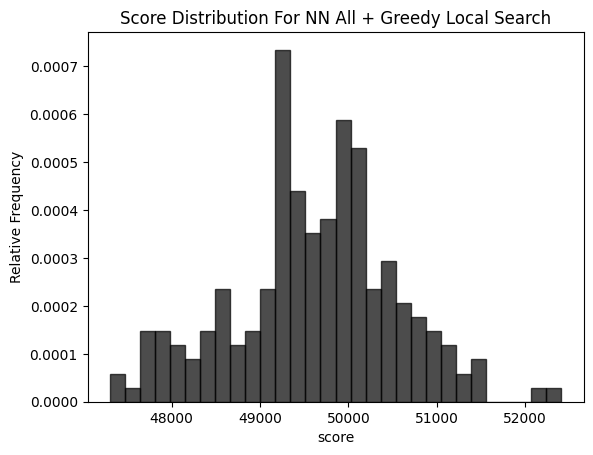

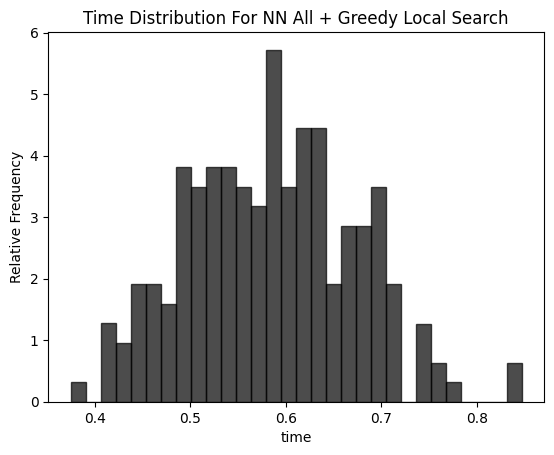

___________________________________________________________________
For Node: 125


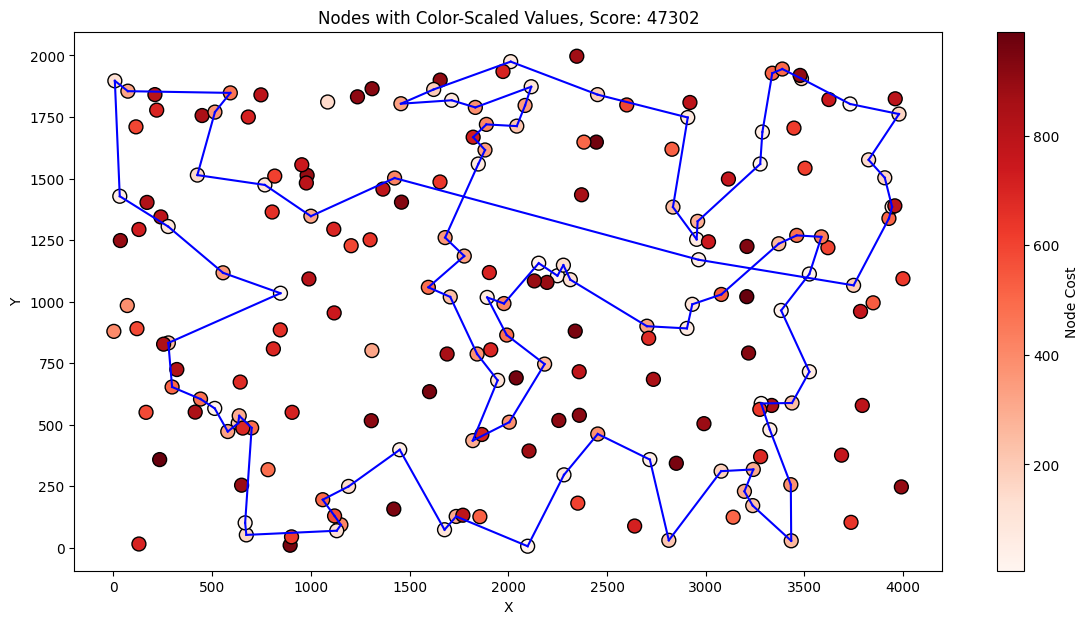

___________________________________________________________________
For Node: 39


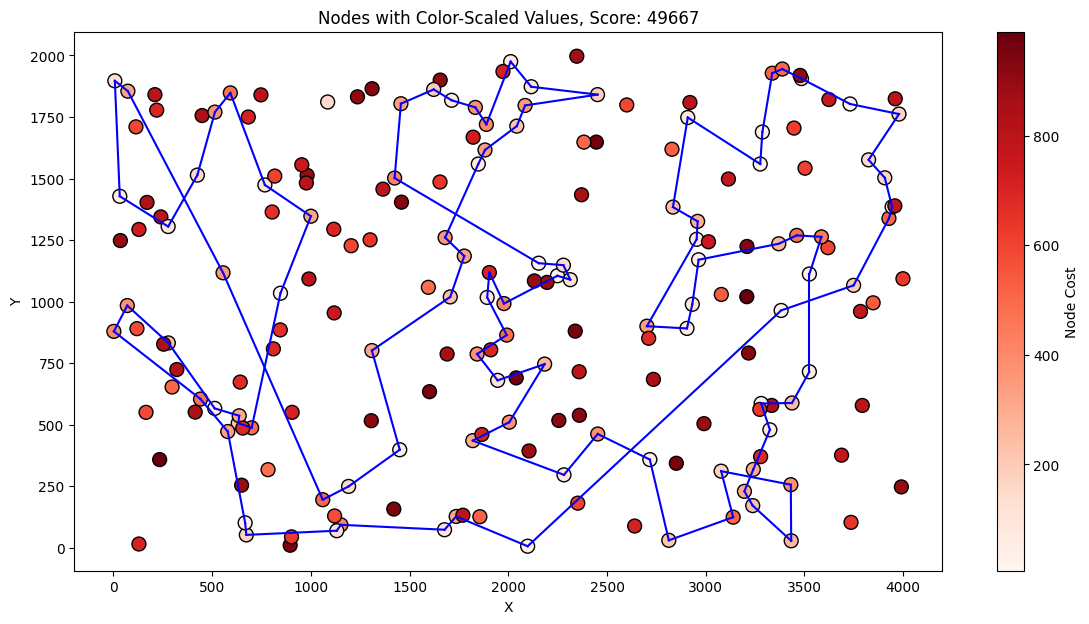

___________________________________________________________________
For Node: 101


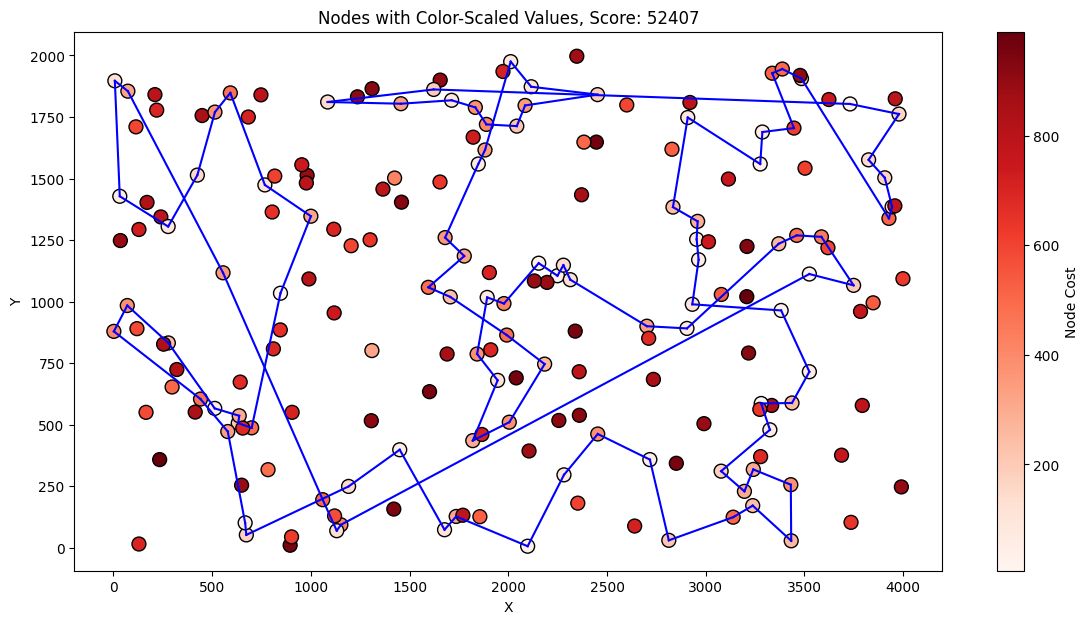

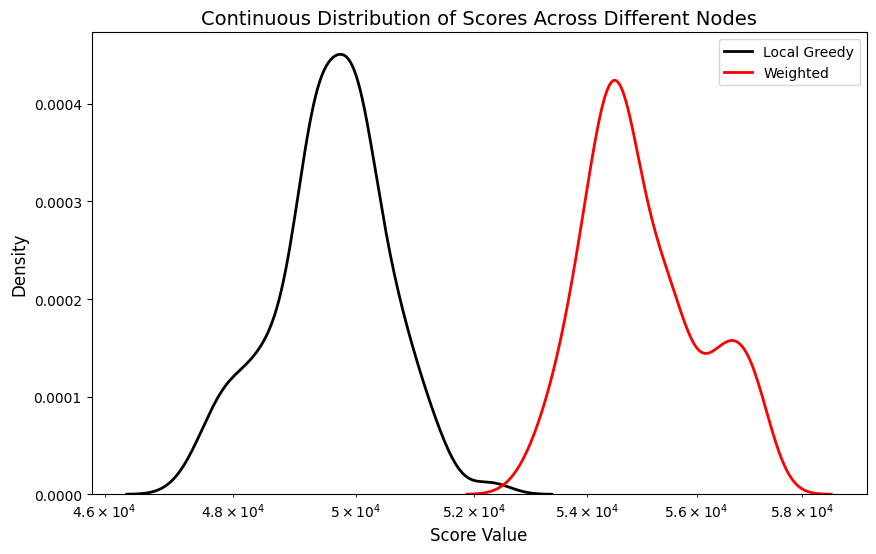

Overall Stats: 
 Minimum: 47302 Maximum: 52407 Median: 49666.0 Mean: 49619.51 Standard Deviation: 924.6466405605981
Time Stats: 
 Minimum: 0.3750002384185791 Maximum: 0.8470034599304199 Median: 0.585979700088501 Mean: 0.5849501371383667 Standard Deviation: 0.08824496057046302
Comparison Stats: 
 Minimum: 3753 Maximum: 3753 Median: 5361.5 Mean: 5396.335 Standard Deviation: 792.4356205869345 and Relative: 0.09797671021183728


In [35]:
plot_score_distribution(nn_greedy_local_result_B, label="NN All + Greedy Local Search", title = "Score Distribution For NN All + Greedy Local Search", x_label = "score")
plot_score_distribution(nn_greedy_local_times_B, label="Times NN All + Greedy Local Search", title = "Time Distribution For NN All + Greedy Local Search", x_label = "time")
plot_best_overall(df_B, nn_greedy_local_solution_B, nn_greedy_local_result_B)
plot_average_overall(df_B, nn_greedy_local_solution_B, nn_greedy_local_result_B)
plot_worst_overall(df_B, nn_greedy_local_solution_B, nn_greedy_local_result_B)
plot_score_distributions(nn_greedy_local_result_B, nn_greedy_local_intermidiate_B, labels = ["Local Greedy", "NN All"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(nn_greedy_local_result_B)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(nn_greedy_local_times_B)
min_val, max_val, mean, median, std, relative = compare_improvement(nn_greedy_local_intermidiate_B, nn_greedy_local_result_B)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

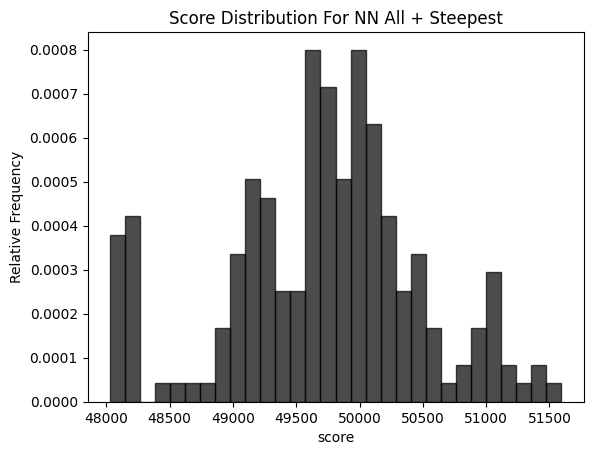

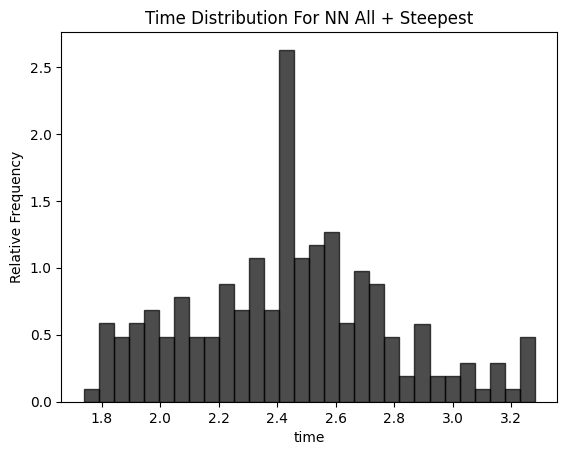

___________________________________________________________________
For Node: 31


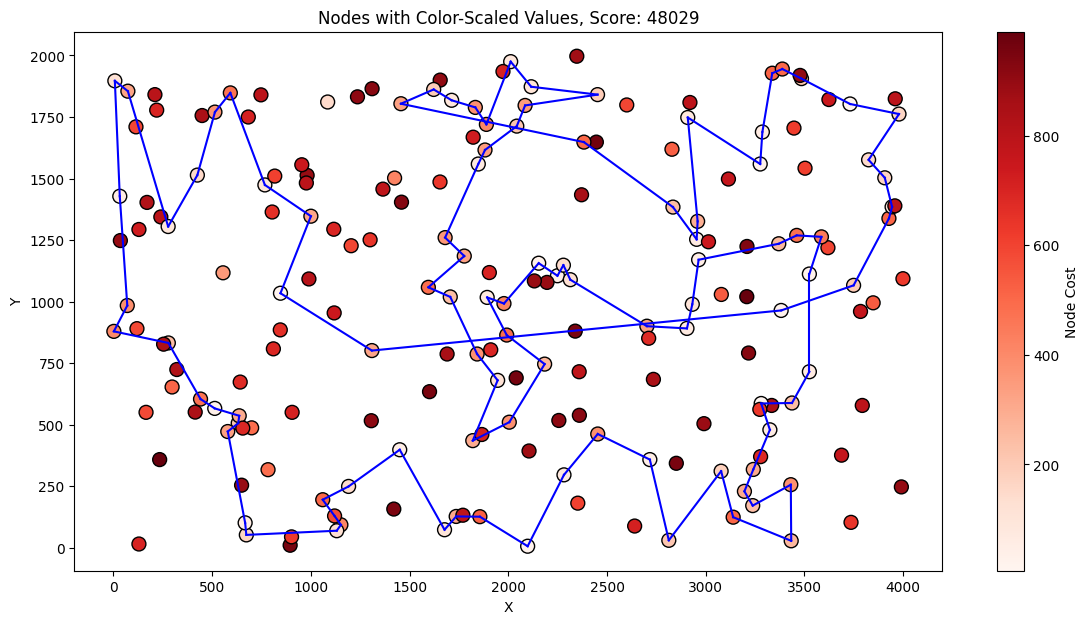

___________________________________________________________________
For Node: 6


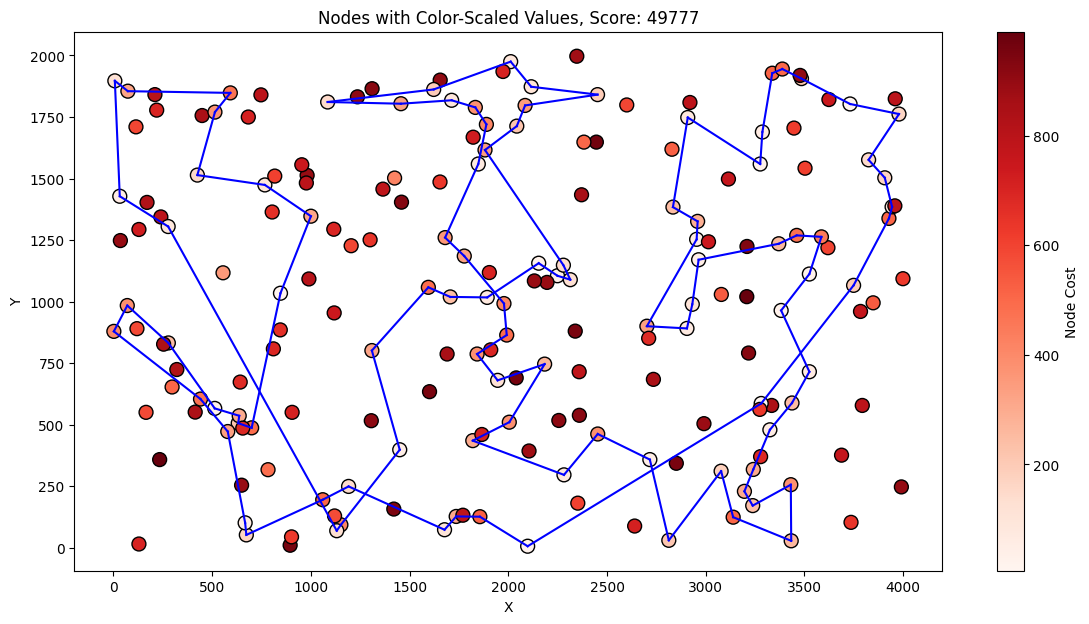

___________________________________________________________________
For Node: 184


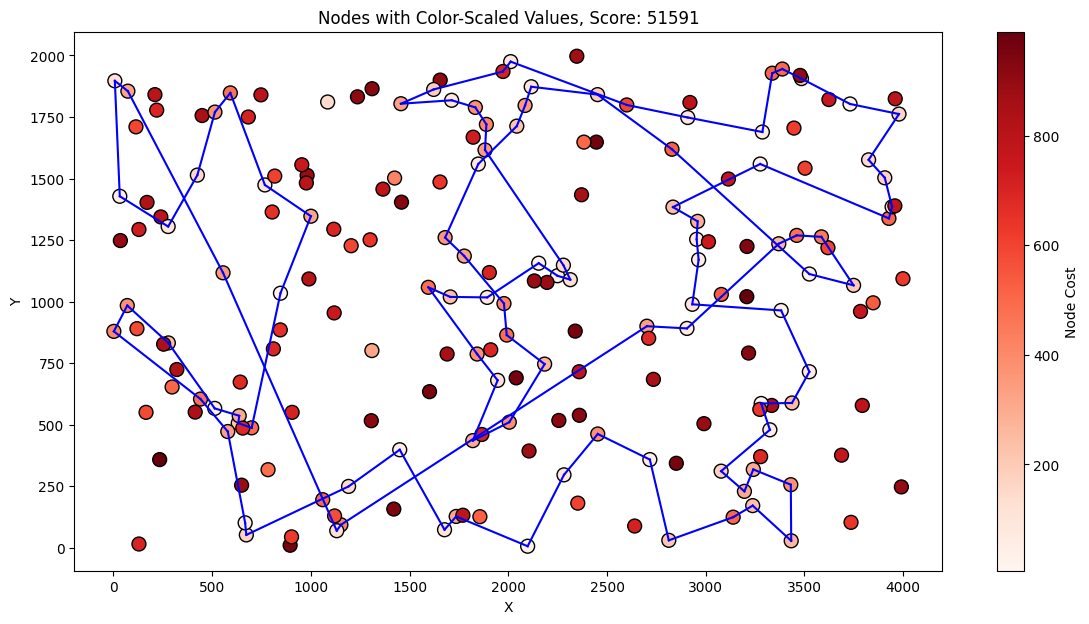

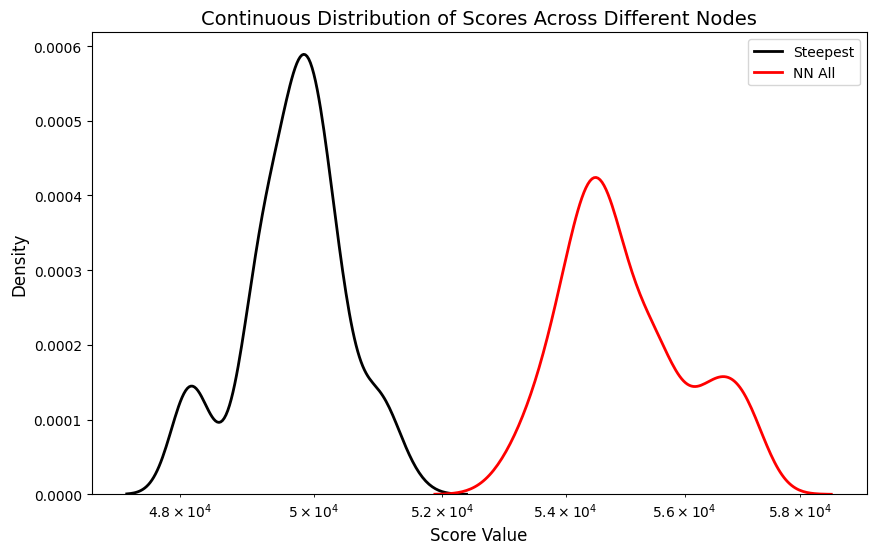

Overall Stats: 
 Minimum: 48029 Maximum: 51591 Median: 49777.0 Mean: 49721.53 Standard Deviation: 768.1942066300683
Time Stats: 
 Minimum: 1.7389683723449707 Maximum: 3.279999017715454 Median: 2.4379844665527344 Mean: 2.4405906319618227 Standard Deviation: 0.3446062378082621
Comparison Stats: 
 Minimum: 3795 Maximum: 3795 Median: 5248.0 Mean: 5294.315 Standard Deviation: 721.9641997876349 and Relative: 0.09609603917338007


In [36]:
plot_score_distribution(nn_steepest_result_B, label="NN All + Steepest", title = "Score Distribution For NN All + Steepest", x_label = "score")
plot_score_distribution(nn_steepest_times_B, label="Times NN All + Steepest", title = "Time Distribution For NN All + Steepest", x_label = "time")
plot_best_overall(df_B, nn_steepest_solution_B, nn_steepest_result_B)
plot_average_overall(df_B, nn_steepest_solution_B, nn_steepest_result_B)
plot_worst_overall(df_B, nn_steepest_solution_B, nn_steepest_result_B)
plot_score_distributions(nn_steepest_result_B, nn_steepest_intermidiate_B, labels = ["Steepest", "NN All"])
min_score, max_score, median_score, mean_score, std_score = calculate_stats_overall(nn_steepest_result_B)
min_time, max_time, median_time, mean_time, std_time = calculate_stats_overall(nn_steepest_times_B)
min_val, max_val, mean, median, std, relative = compare_improvement(nn_steepest_intermidiate_B, nn_steepest_result_B)
print(f"Overall Stats: \n Minimum: {min_score} Maximum: {max_score} Median: {median_score} Mean: {mean_score} Standard Deviation: {std_score}")
print(f"Time Stats: \n Minimum: {min_time} Maximum: {max_time} Median: {median_time} Mean: {mean_time} Standard Deviation: {std_time}")
print(f"Comparison Stats: \n Minimum: {min_val} Maximum: {max_val} Median: {median} Mean: {mean} Standard Deviation: {std} and Relative: {relative}")

## Comparing Both Instances

In [37]:
def plot_all_distributions(score_dict_1, score_dict_2, score_dict_3, score_dict_4, labels):
    all_scores_1 = []
    for key in score_dict_1.keys():
        item = score_dict_1[key]
        all_scores_1.append(item)

    all_scores_2 = []
    for key in score_dict_2.keys():
        item = score_dict_2[key]
        all_scores_2.append(item)

    all_scores_3 = []
    for key in score_dict_3.keys():
        item = score_dict_3[key]
        all_scores_3.append(item)

    all_scores_4 = []
    for key in score_dict_4.keys():
        item = score_dict_4[key]
        all_scores_4.append(item)
    
    plt.figure(figsize=(18, 12))

    all_scores_1 = np.array(all_scores_1)
    all_scores_2 = np.array(all_scores_2)
    all_scores_3 = np.array(all_scores_3)
    all_scores_4 = np.array(all_scores_4)

    to_plot = [np.mean(all_scores_1), np.mean(all_scores_2), np.mean(all_scores_3), np.mean(all_scores_4)]
    sorted_indices = np.argsort(to_plot)[::-1]
    to_plot_sorted = np.array(to_plot)[sorted_indices]
    labels_sorted = np.array(labels)[sorted_indices]

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.yscale('log')
    plt.bar(labels_sorted, to_plot_sorted, color=['blue', 'red', 'green', 'black'])

    # Adding title and labels
    plt.title('Comparison of Mean Scores Across Different TSP Algorithms', fontsize=14)
    plt.xlabel('TSP Algorithms', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean Score Logarithmic Scale)', fontsize=12)

<Figure size 1800x1200 with 0 Axes>

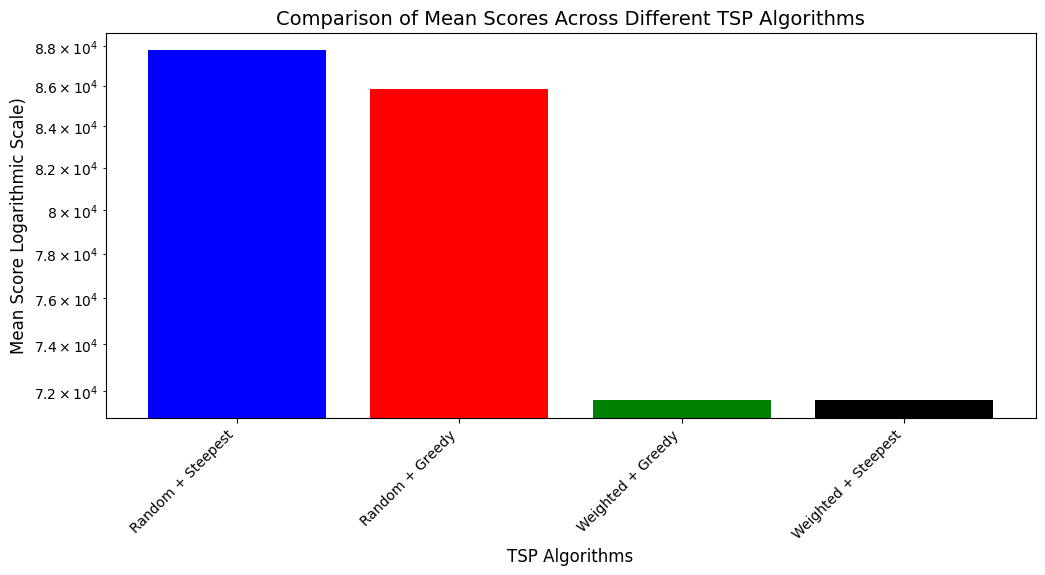

In [38]:
plot_all_distributions(random_greedy_local_result_A, random_steepest_result_A, weighted_greedy_local_result_A, weighted_steepest_result_A, labels = ["Random + Greedy", "Random + Steepest", "Weighted + Greedy", "Weighted + Steepest"])

<Figure size 1800x1200 with 0 Axes>

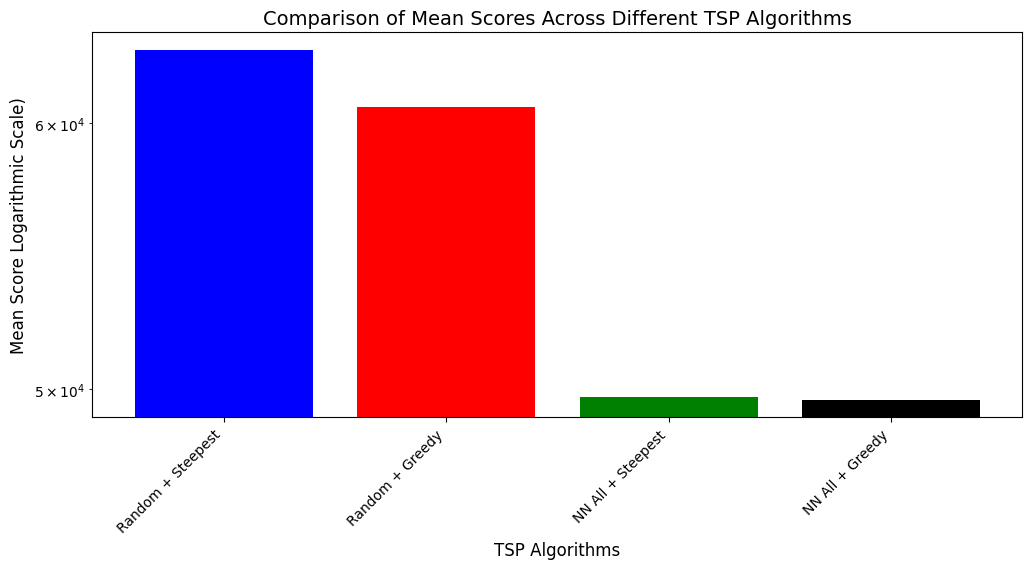

In [39]:
plot_all_distributions(random_greedy_local_result_B, random_steepest_result_B, nn_greedy_local_result_B, nn_steepest_result_B, labels = ["Random + Greedy", "Random + Steepest", "NN All + Greedy", "NN All + Steepest"])